In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
from scipy.linalg import block_diag
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# number of nuisance parameters: must match number of photo-z bins
nz = 10

# Prior over theta
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.ones(nz)*-0.1
eta_upper = np.ones(nz)*0.1
eta_mean = np.zeros(nz)
eta_covariance = np.eye(nz)*0.05**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP THE SIMULATOR ###

# import tomographic n(z)
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearPhotoz(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    # Draw nuisances from prior
    eta_prior = simulator_args[0]
    eta = eta_prior.draw()
    
    return CosmicShearSimulator.simulate(np.concatenate([theta, eta]), seed)
simulator_args = [eta_prior]

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
eta_fiducial = np.zeros(len(pz))

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(np.concatenate([theta_fiducial, eta_fiducial]))
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(np.concatenate([theta_fiducial, eta_fiducial]), h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(np.concatenate([theta_fiducial, eta_fiducial]), nl, Cinv, dCdt, prior_mean=joint_mean, prior_covariance=joint_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv[0:5,0:5]

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.projected_scoreMLE(d, np.arange(5,15))
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
#data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)
data = compressor(C, compressor_args)

In [7]:
# Create the neural density estimator (MDN)
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[25,25], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_marginal/mdn")

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


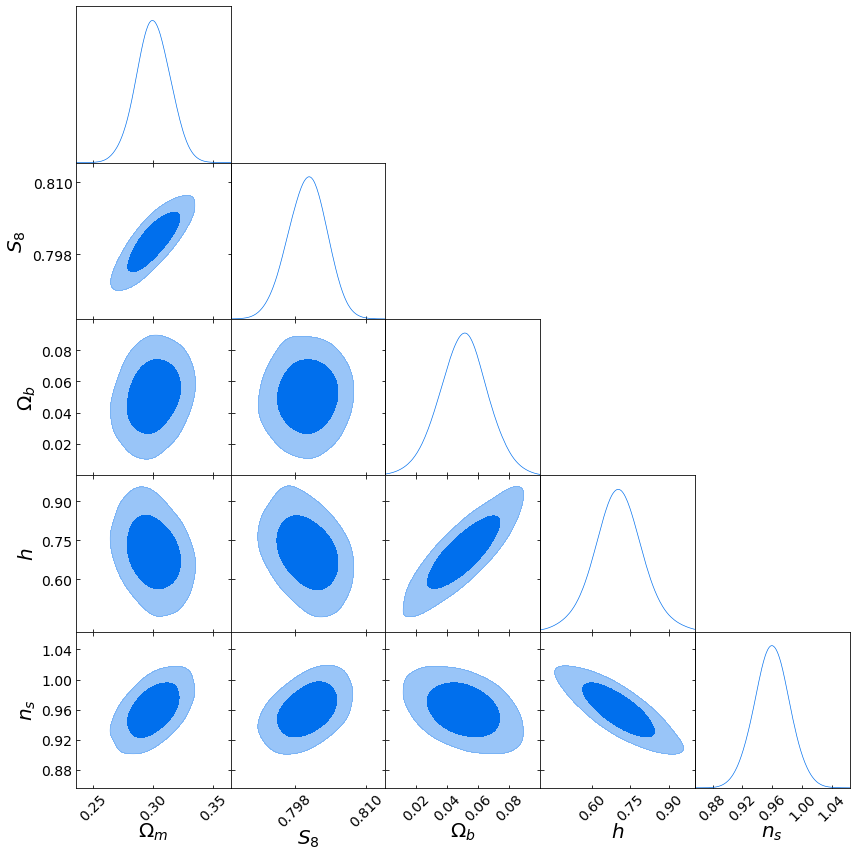

In [8]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


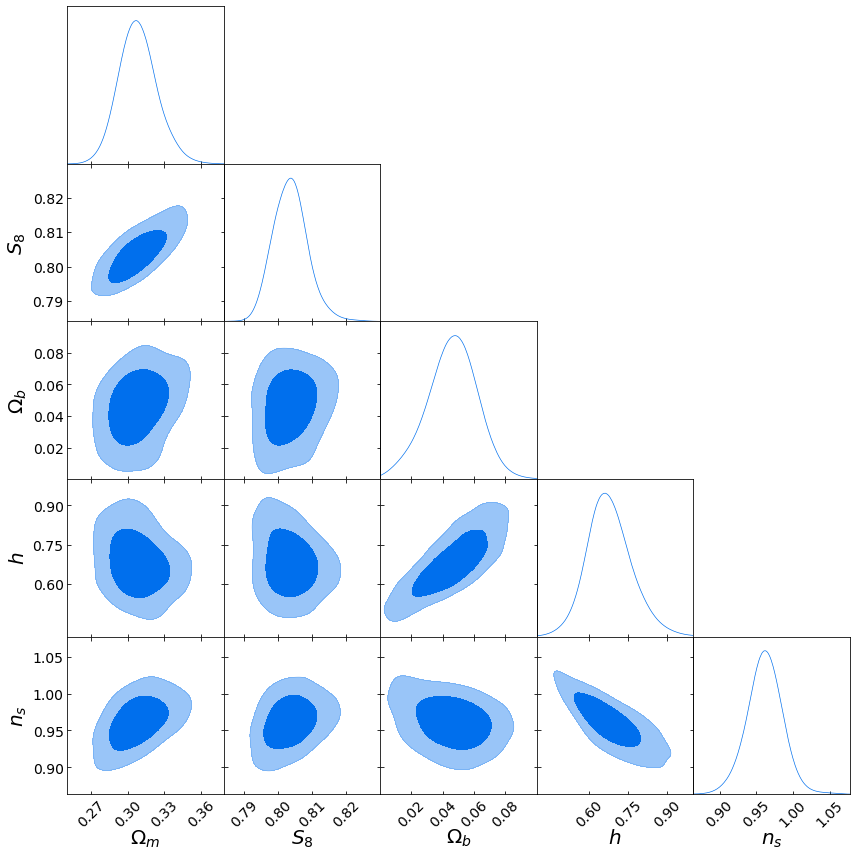

Population 1/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


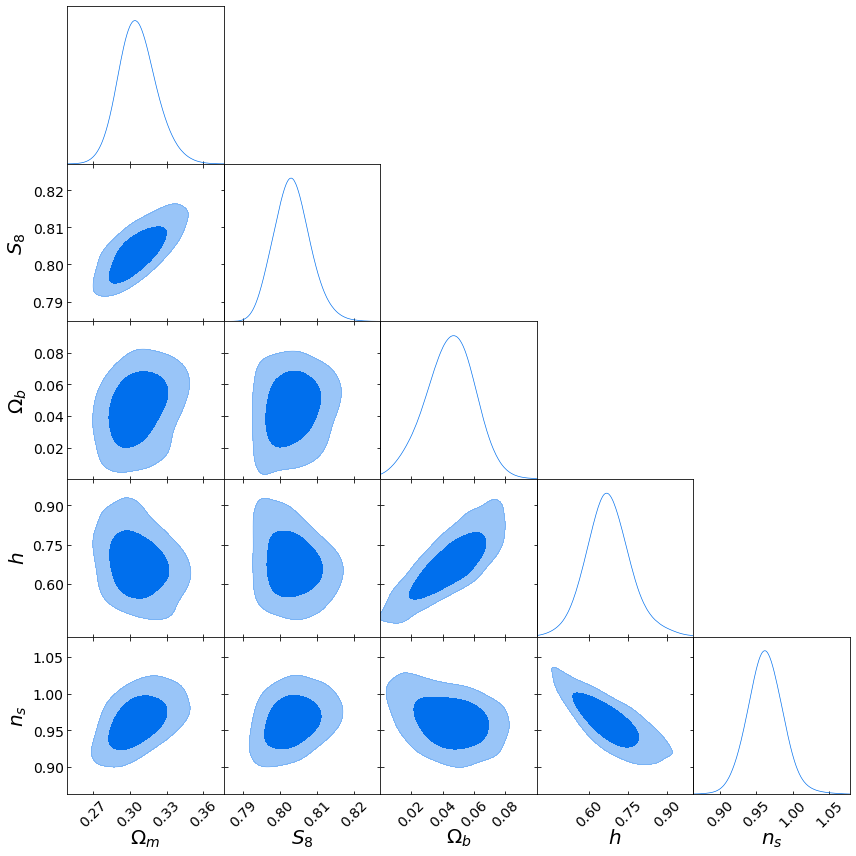

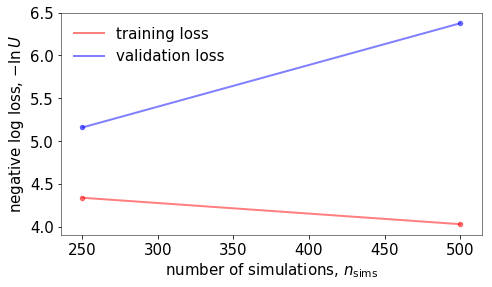

Population 2/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


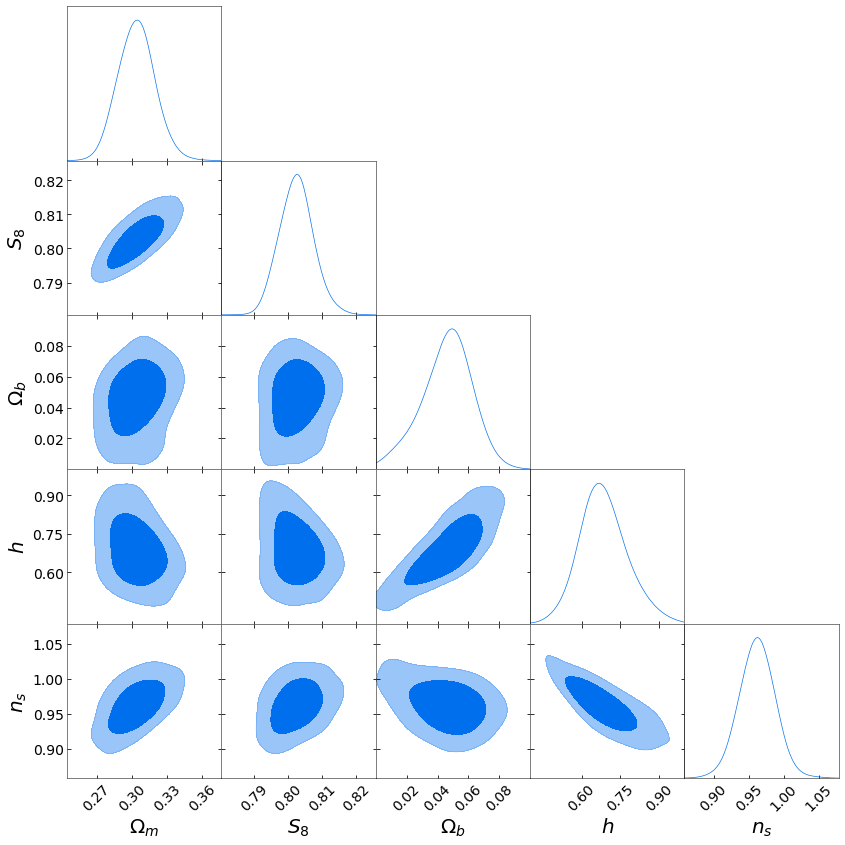

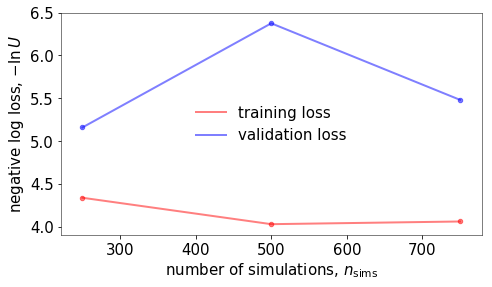

Population 3/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


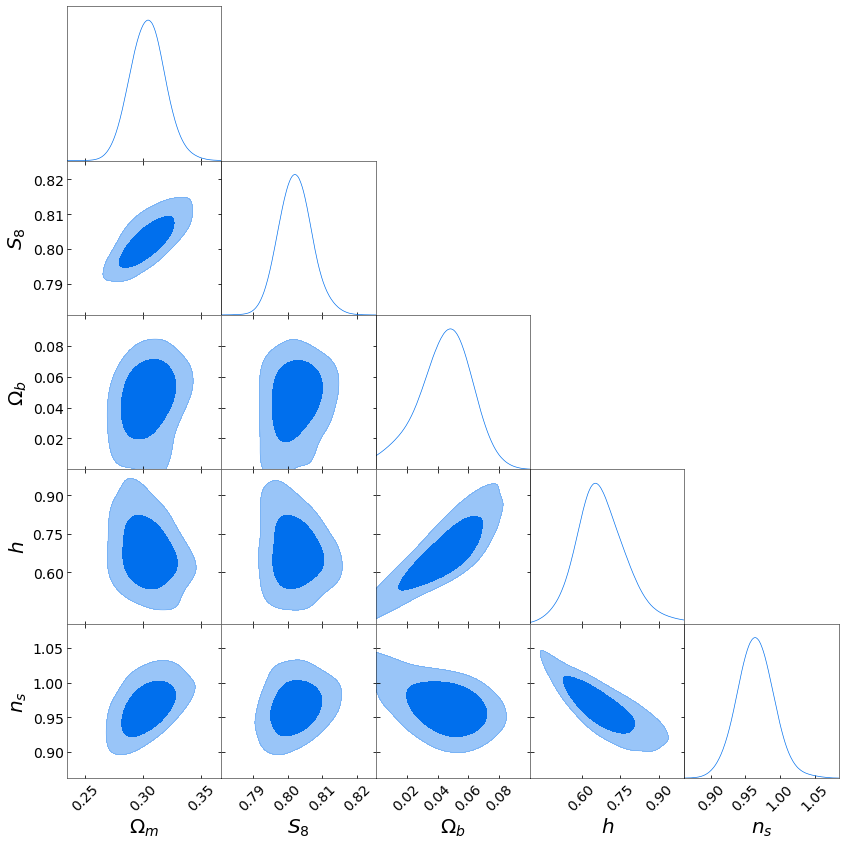

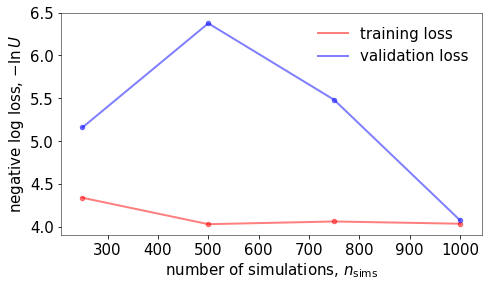

Population 4/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


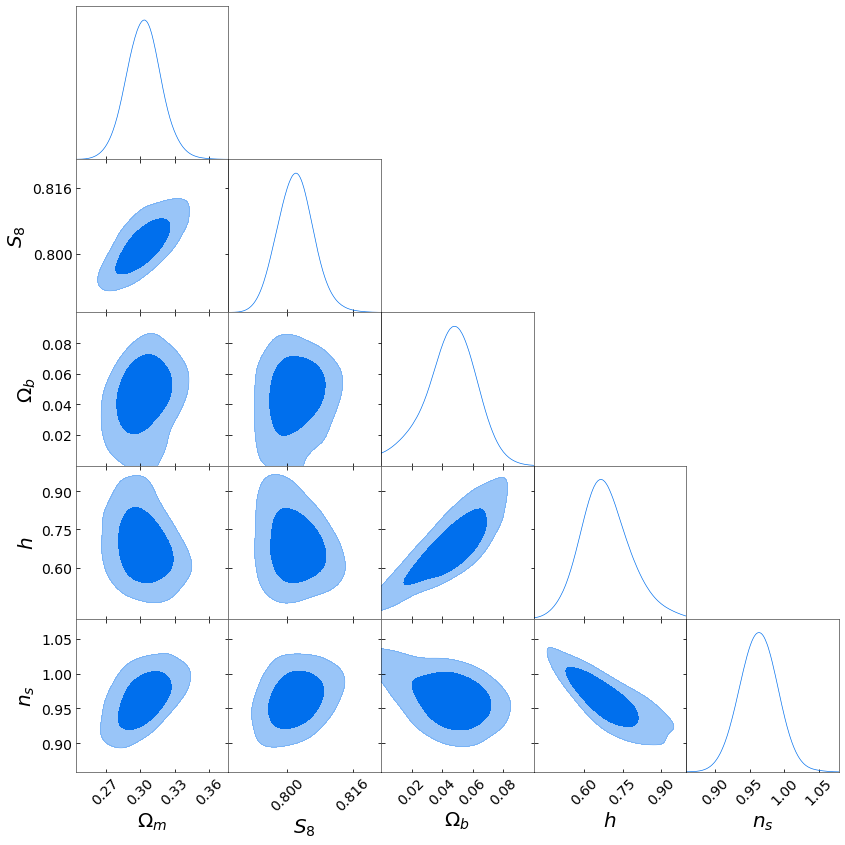

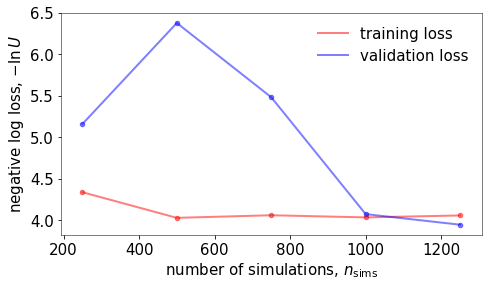

Population 5/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


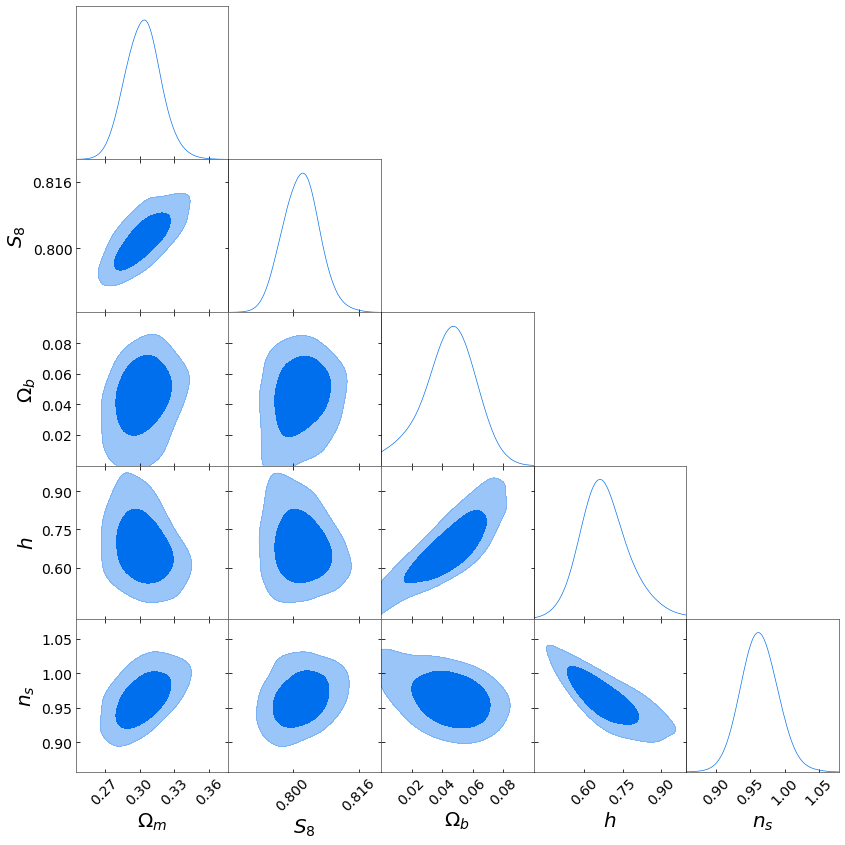

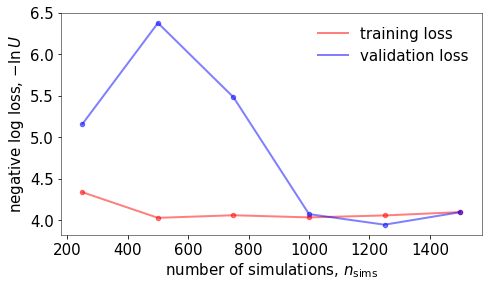

Population 6/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


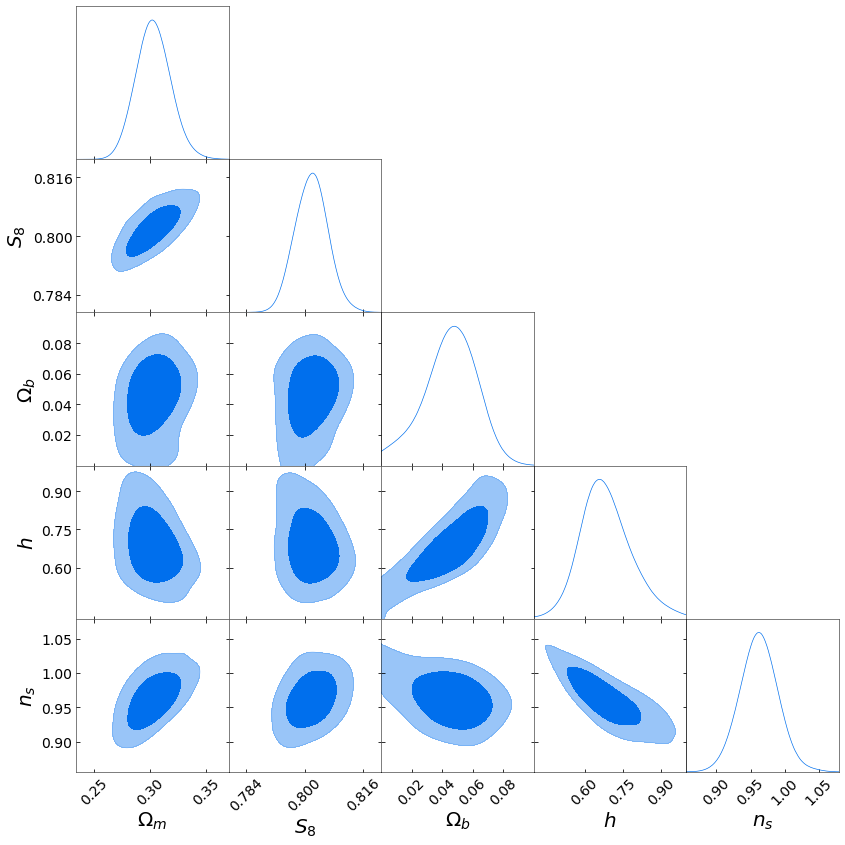

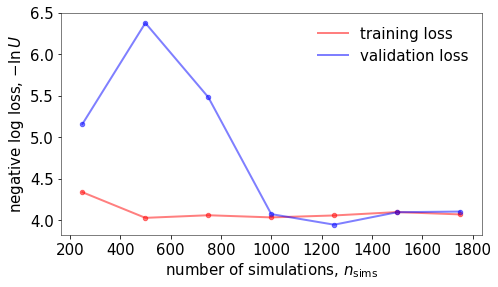

Population 7/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


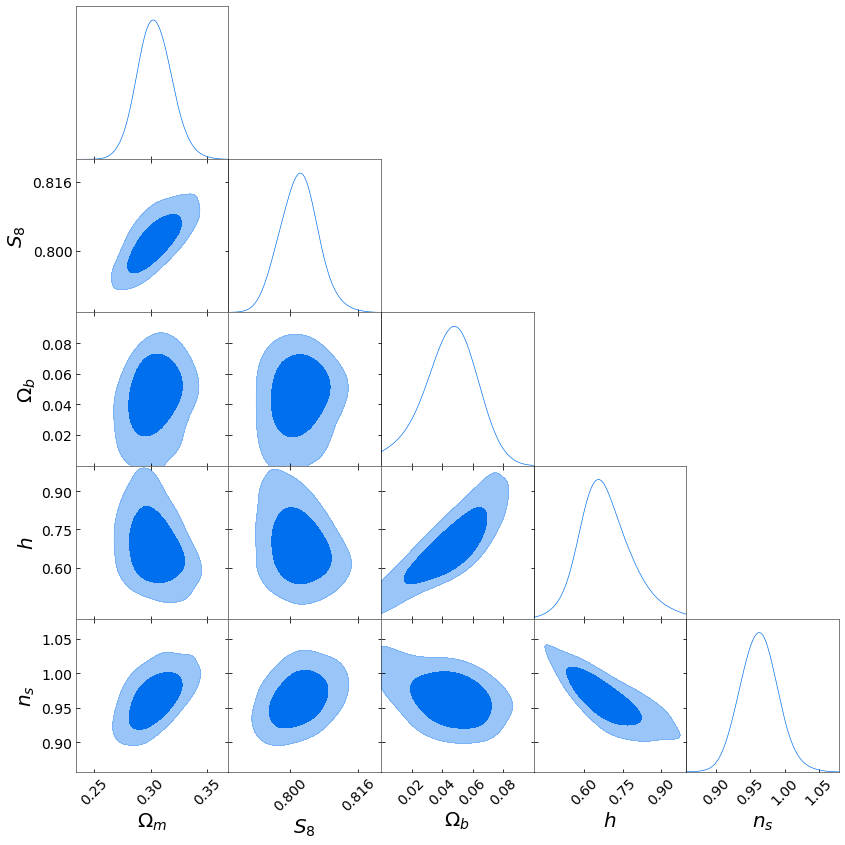

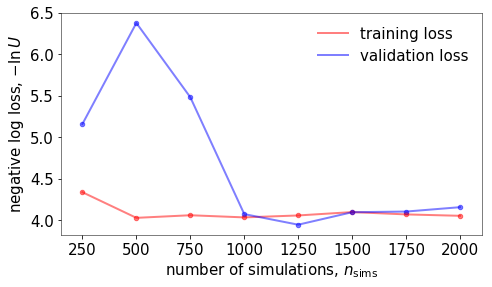

Population 8/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


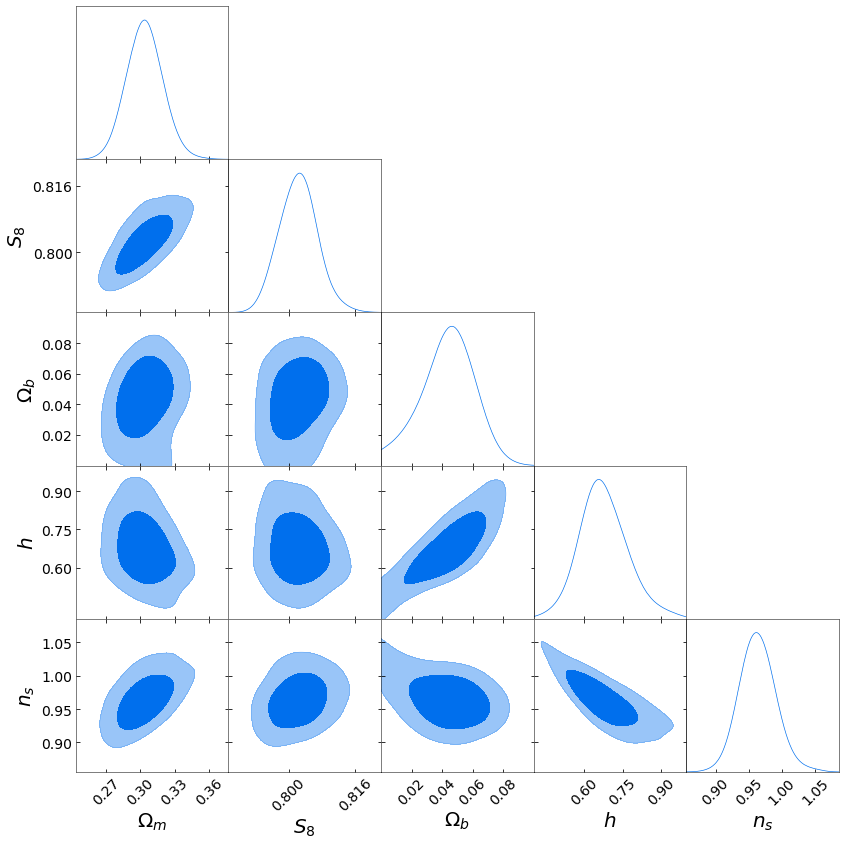

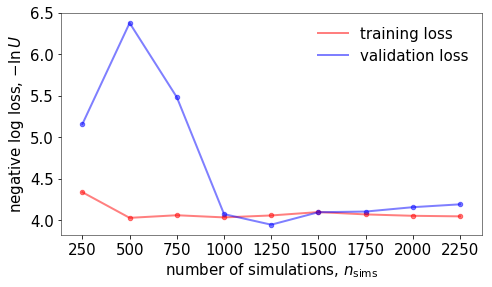

Population 9/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


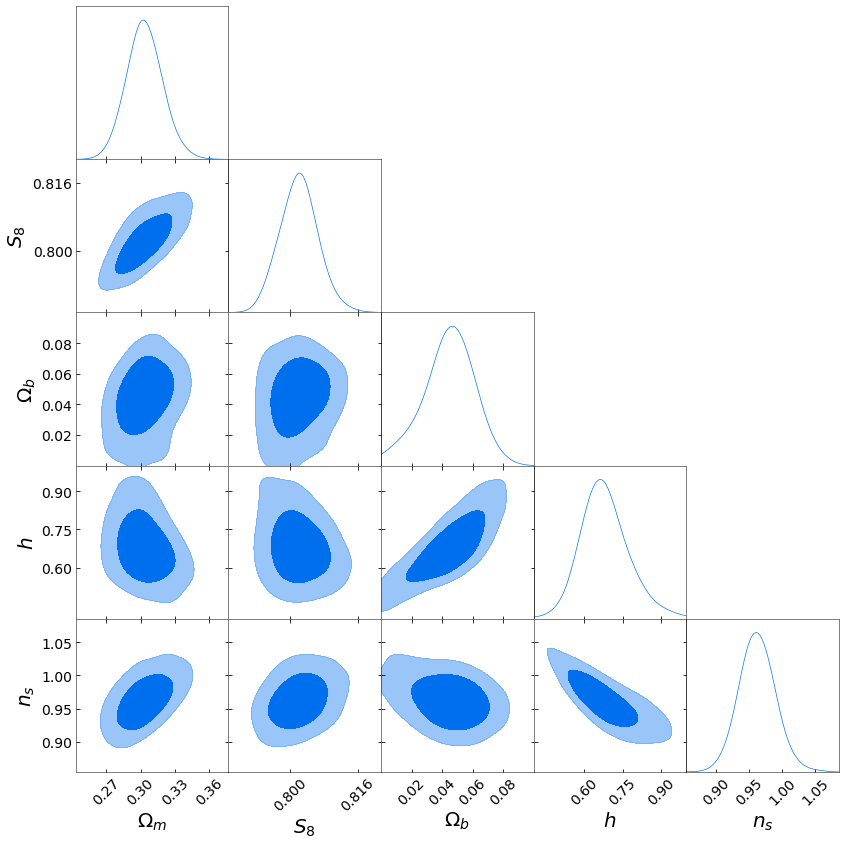

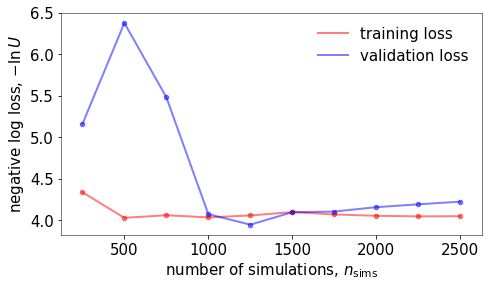

Population 10/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


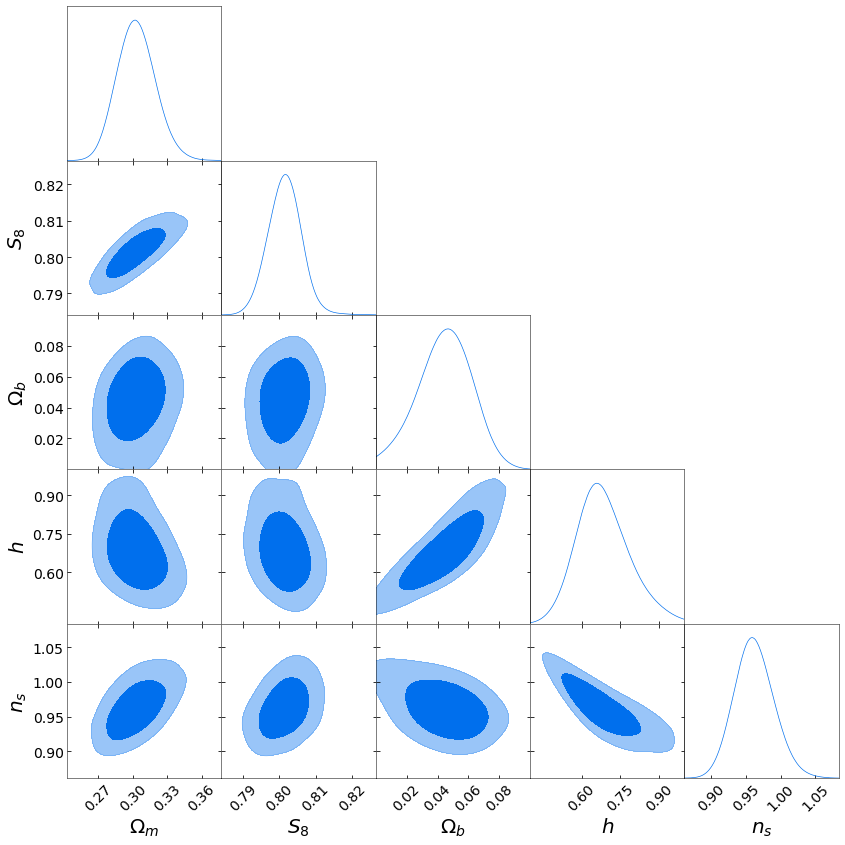

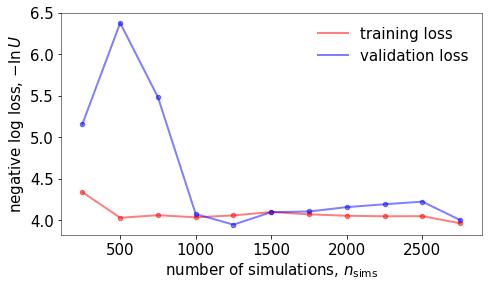

Population 11/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


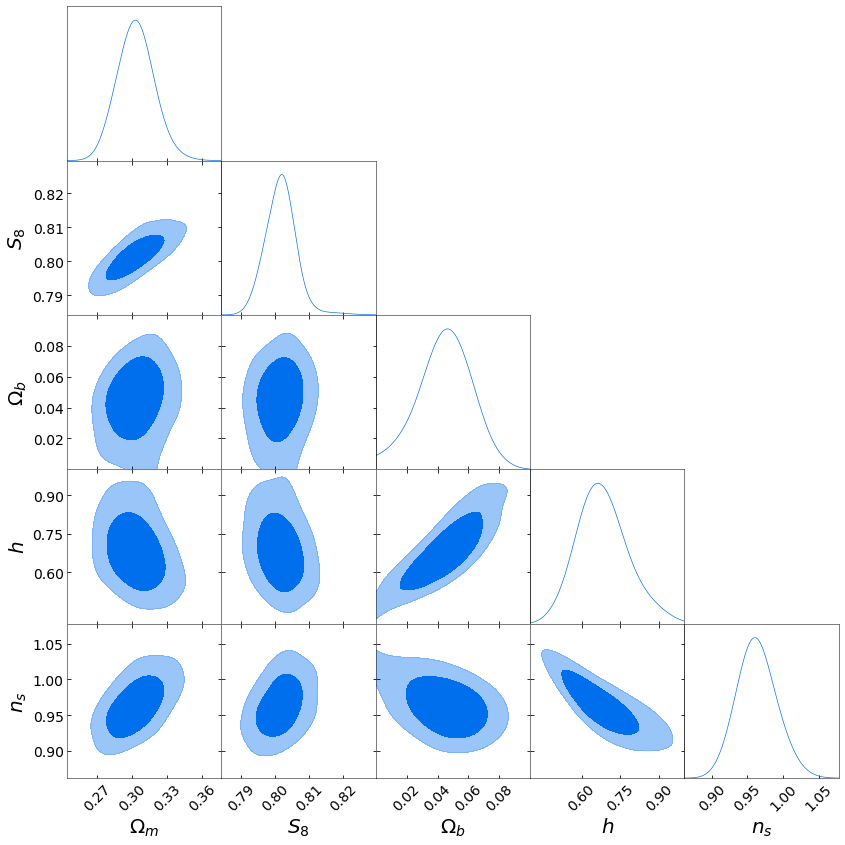

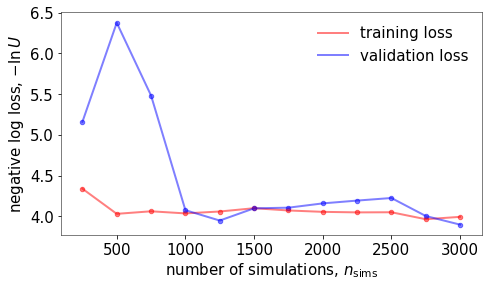

Population 12/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


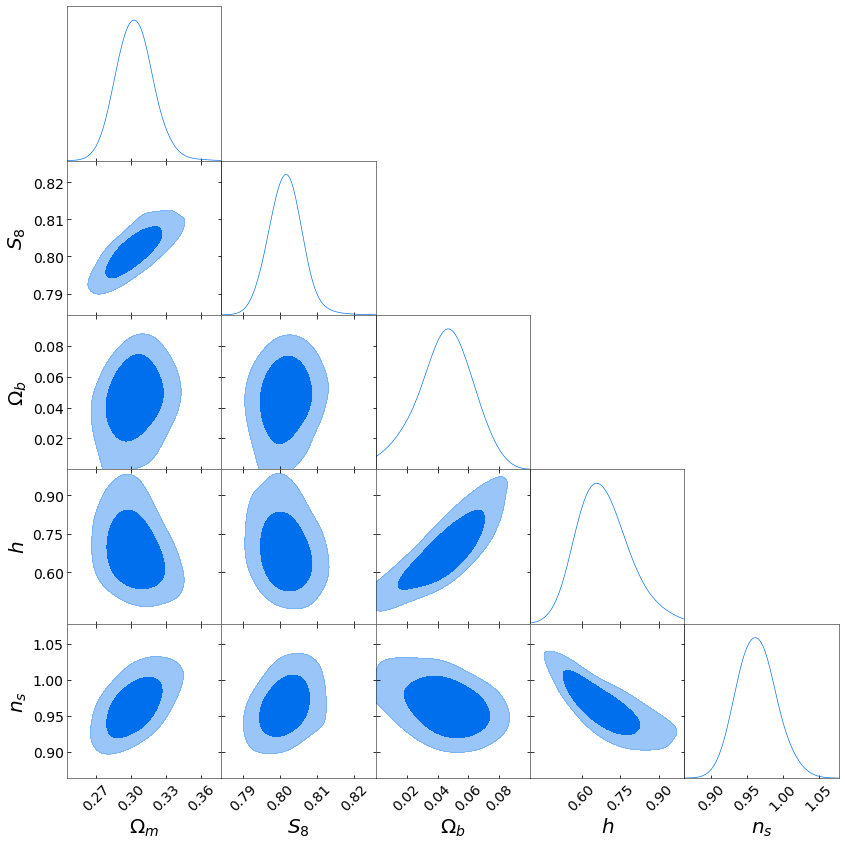

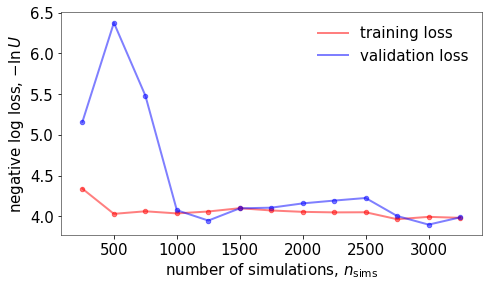

Population 13/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


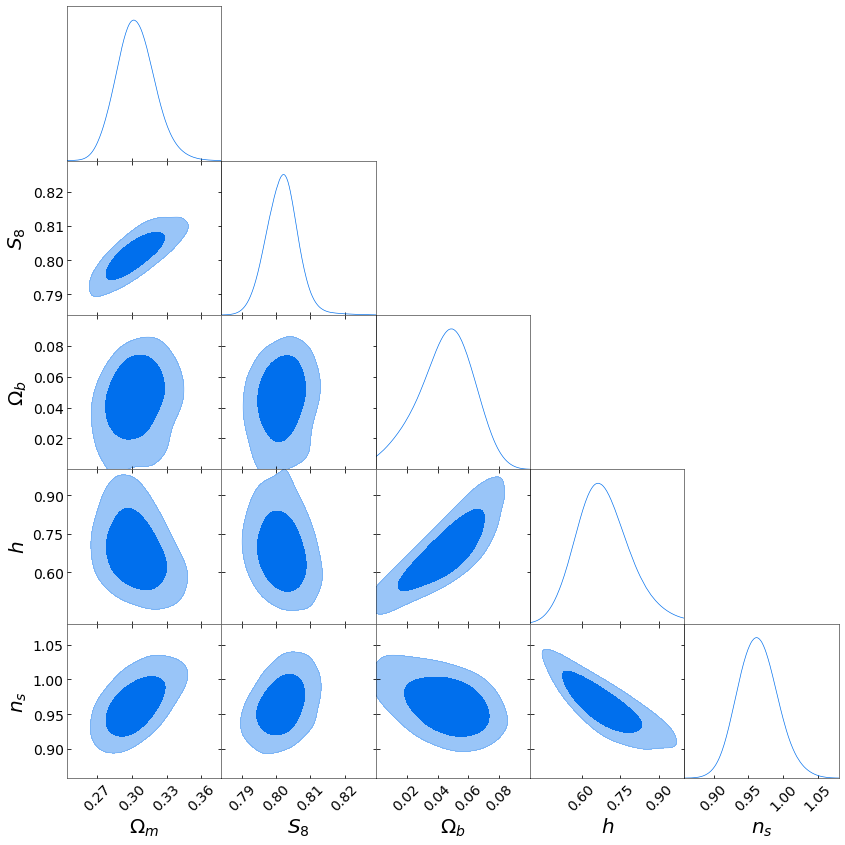

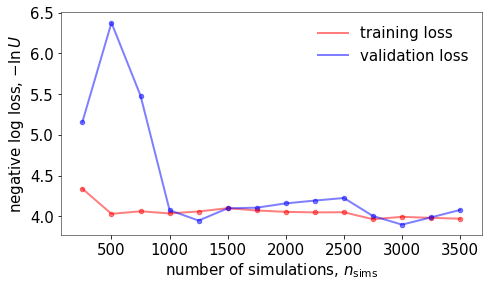

Population 14/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


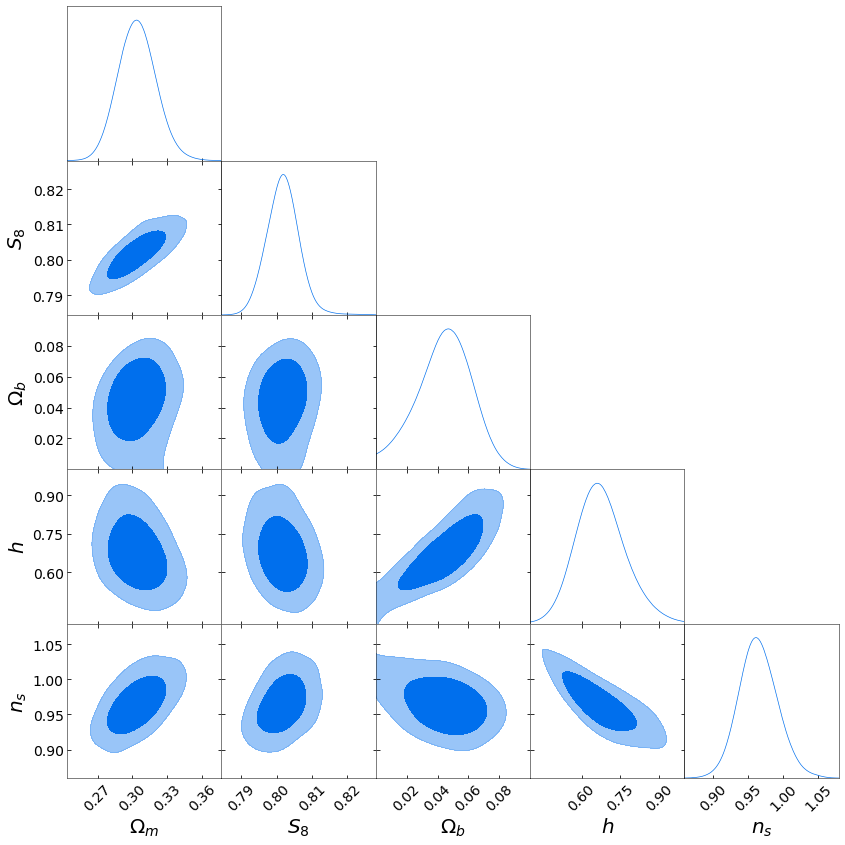

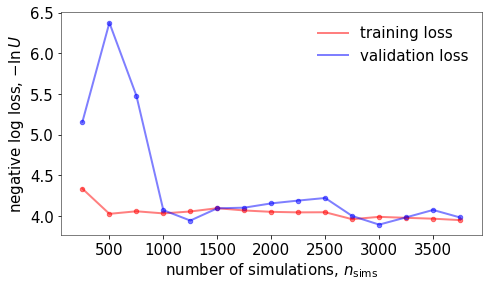

Population 15/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


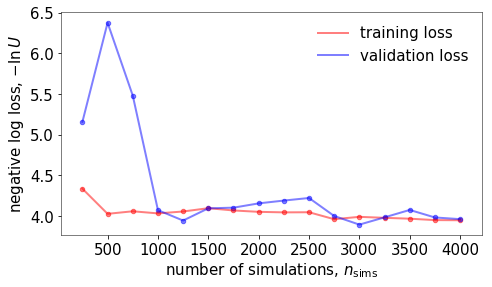

Population 16/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


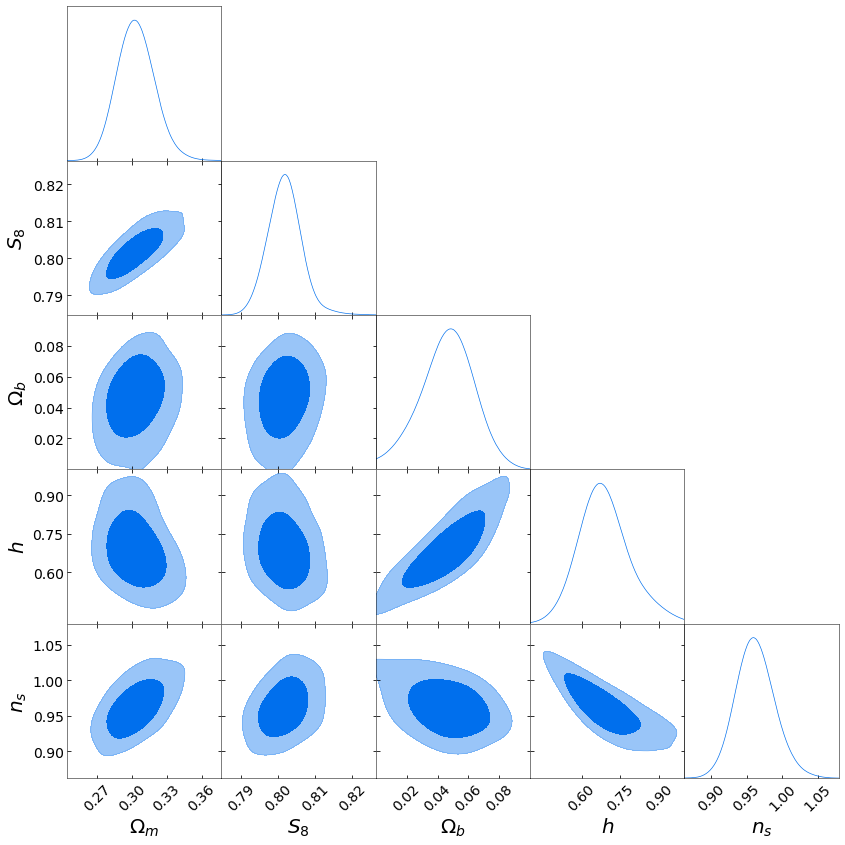

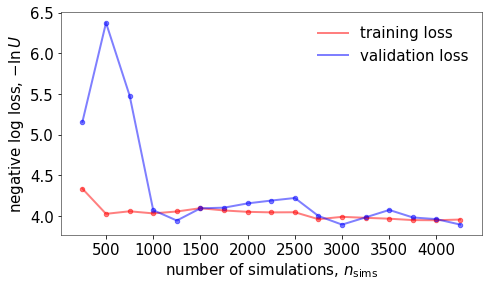

Population 17/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


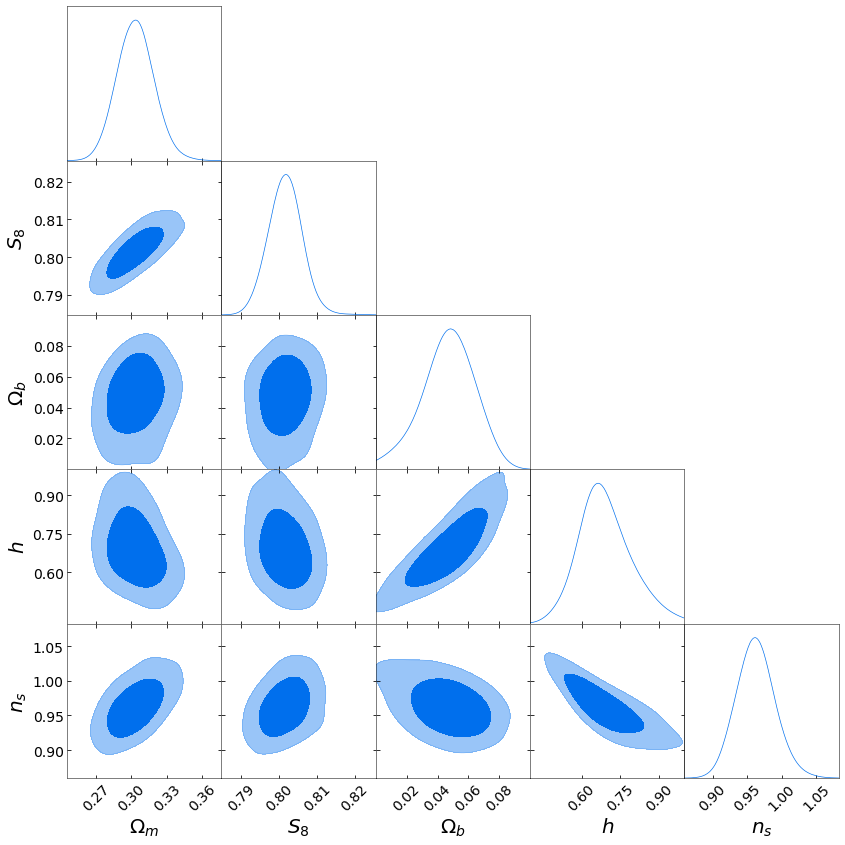

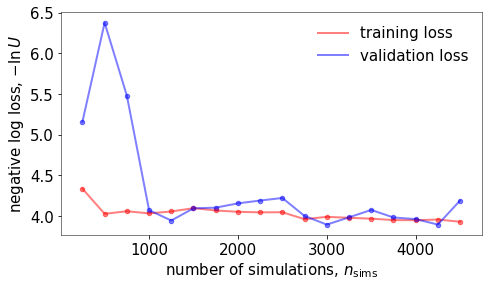

Population 18/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


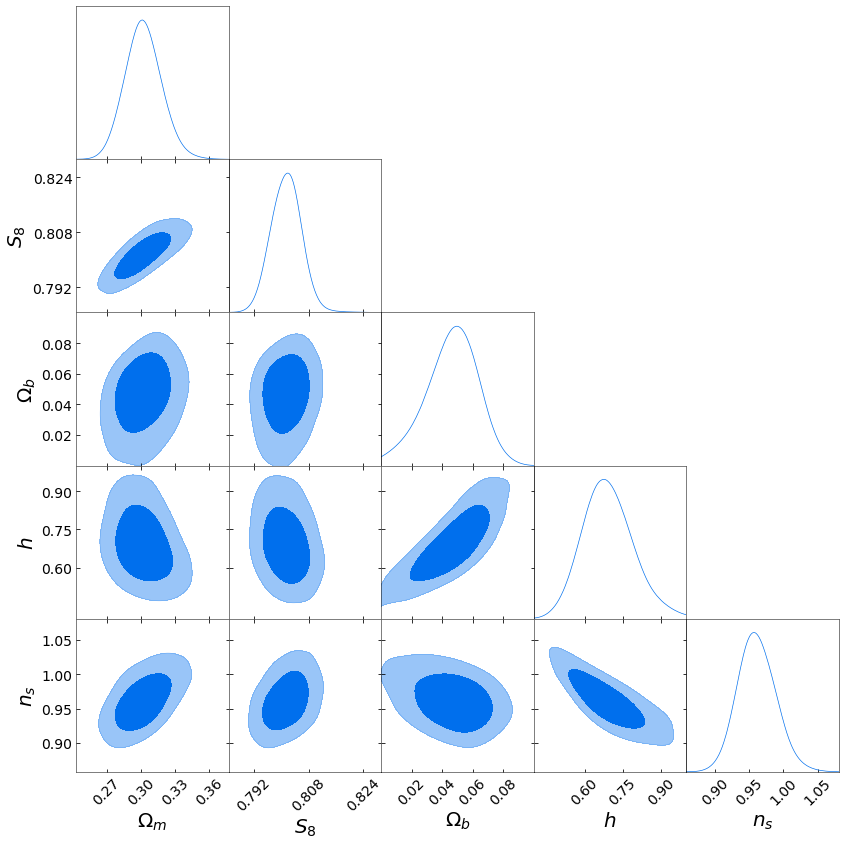

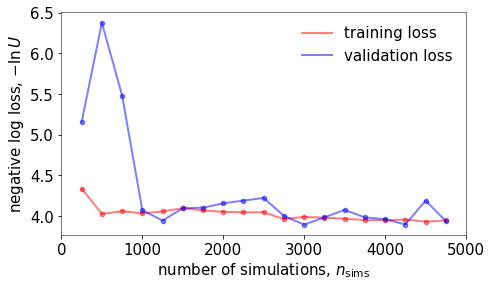

Population 19/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


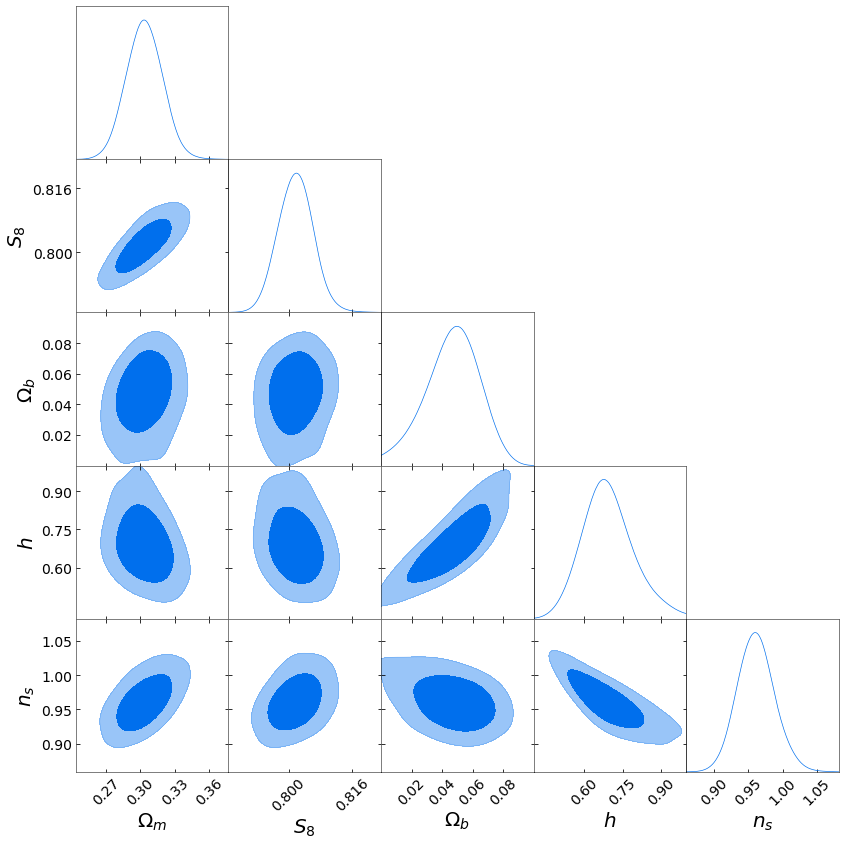

Population 20/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


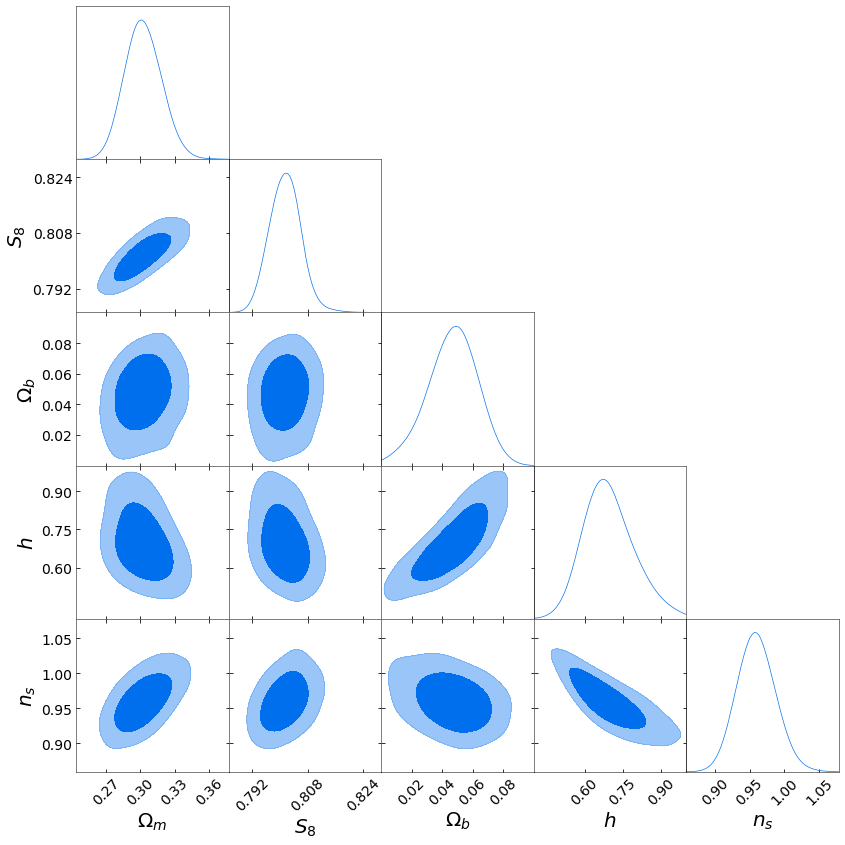

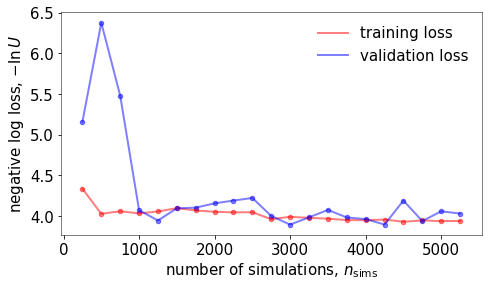

Population 21/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


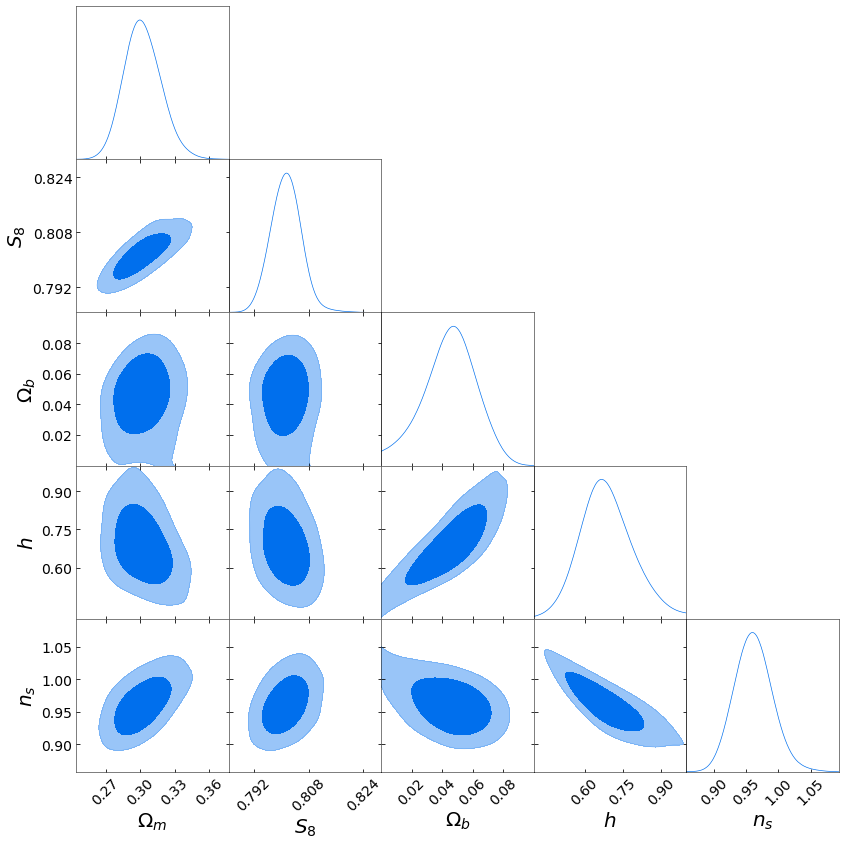

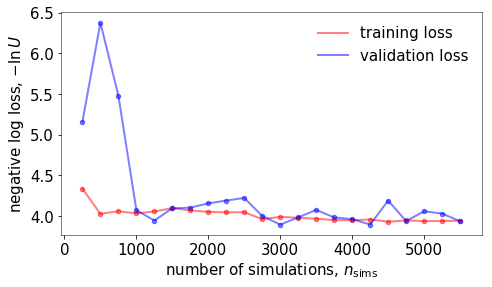

Population 22/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


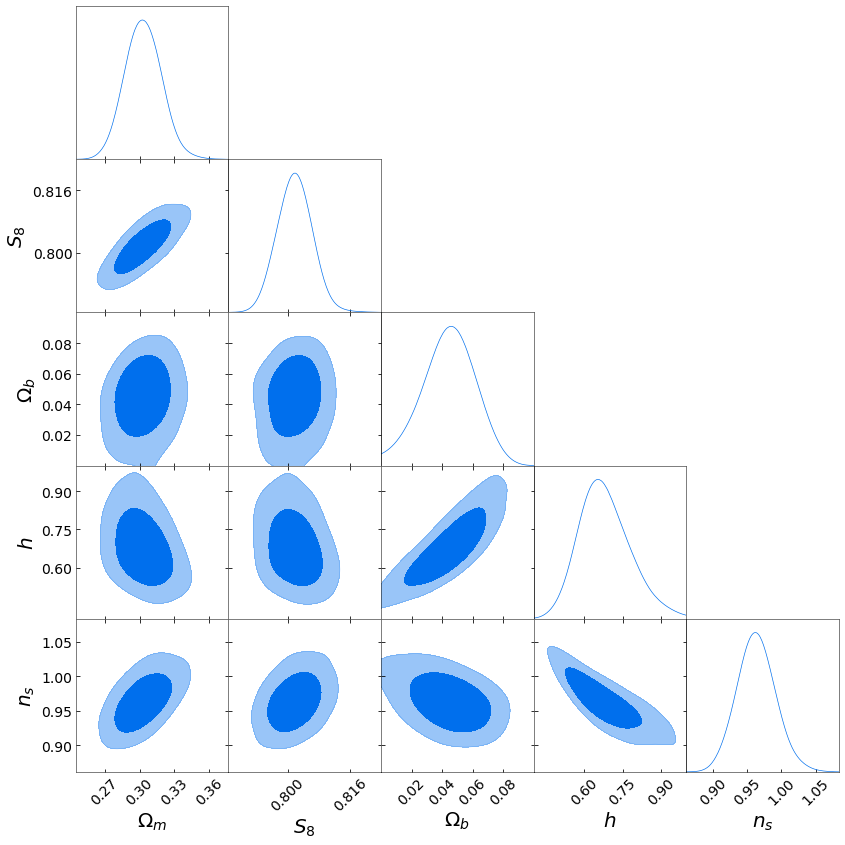

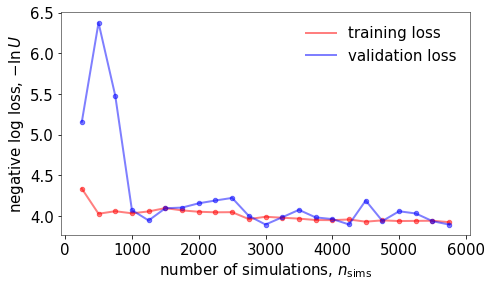

Population 23/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


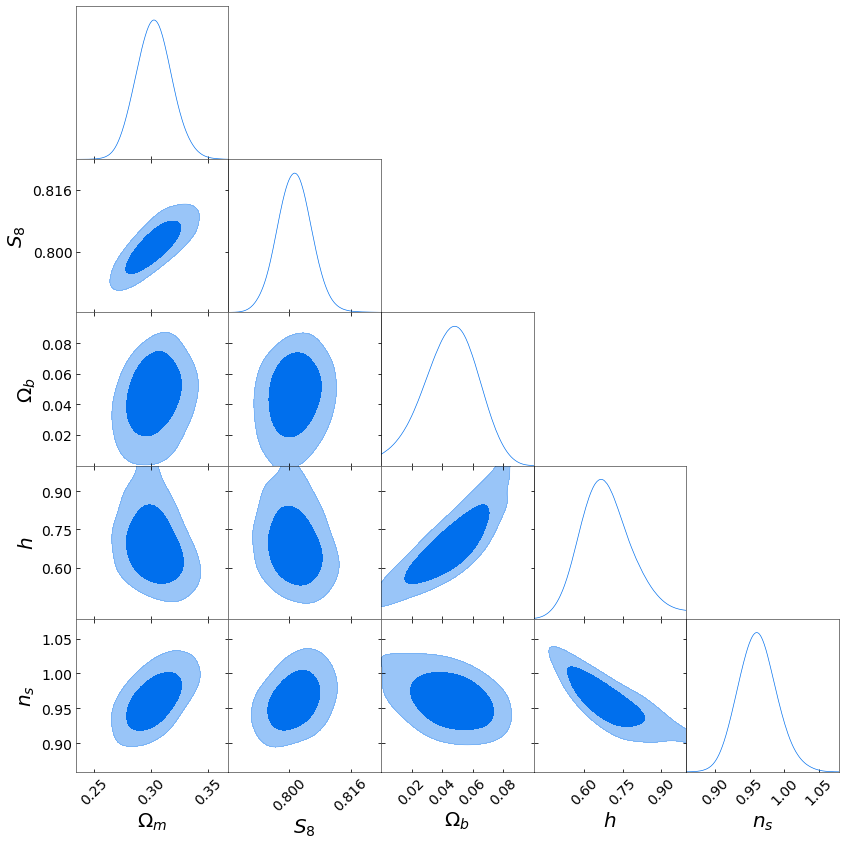

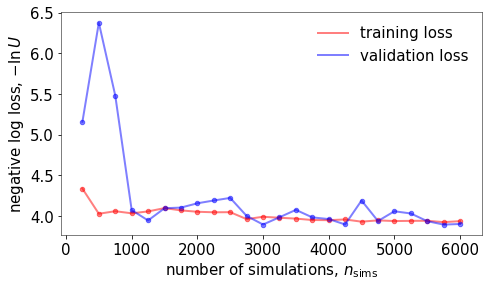

Population 24/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


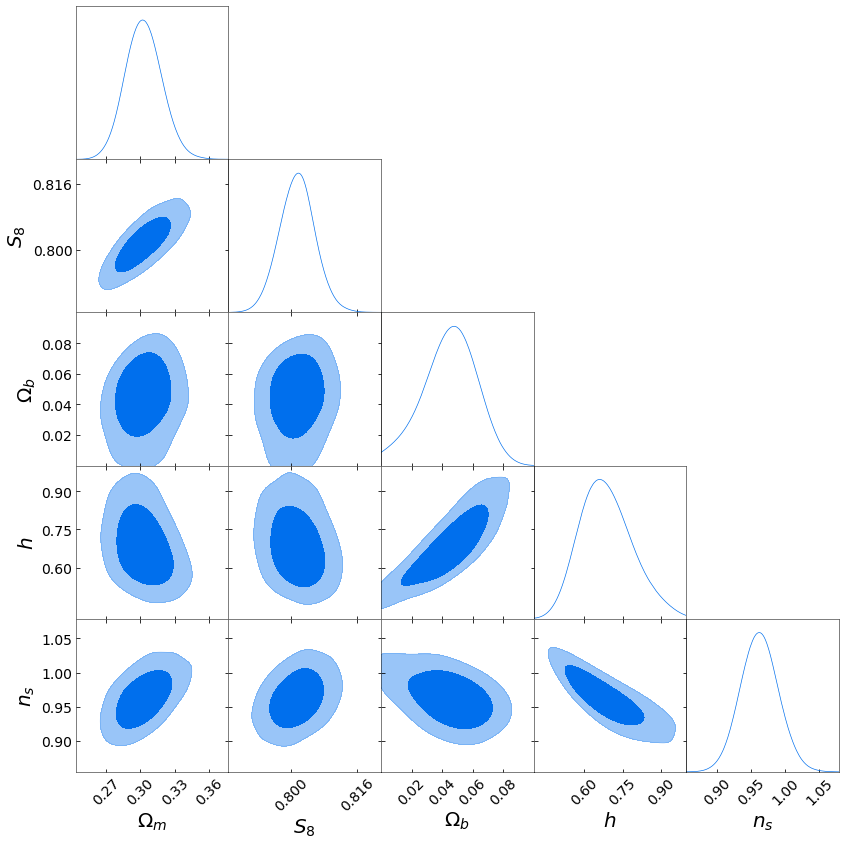

Population 25/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


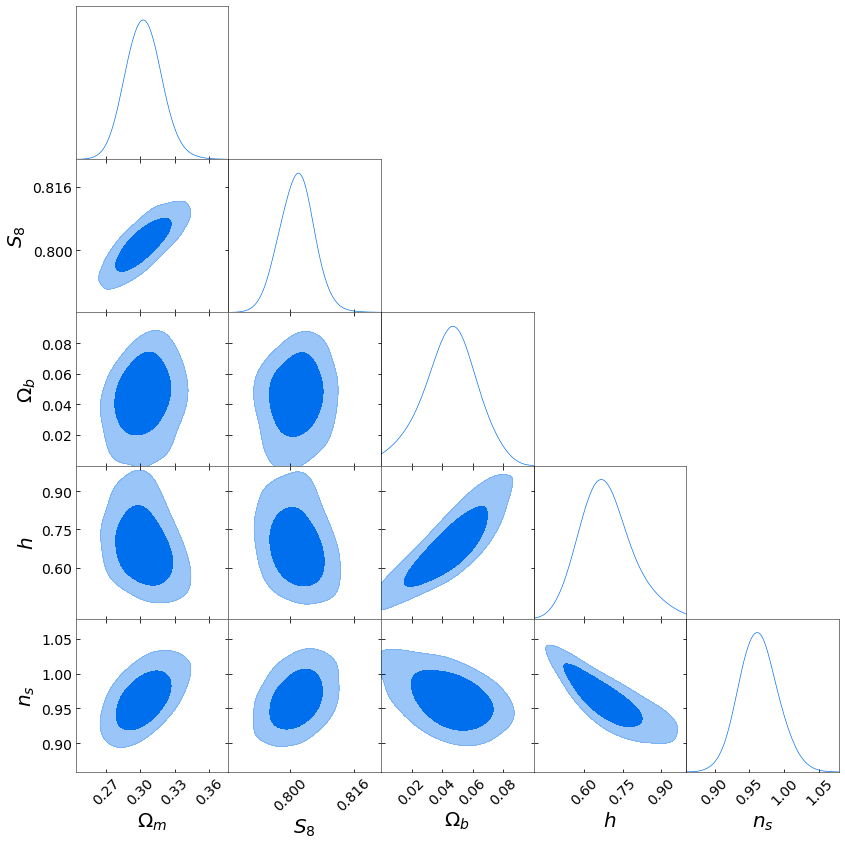

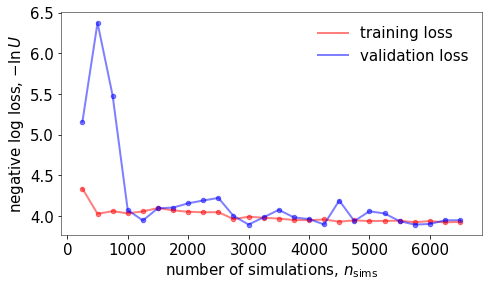

Population 26/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


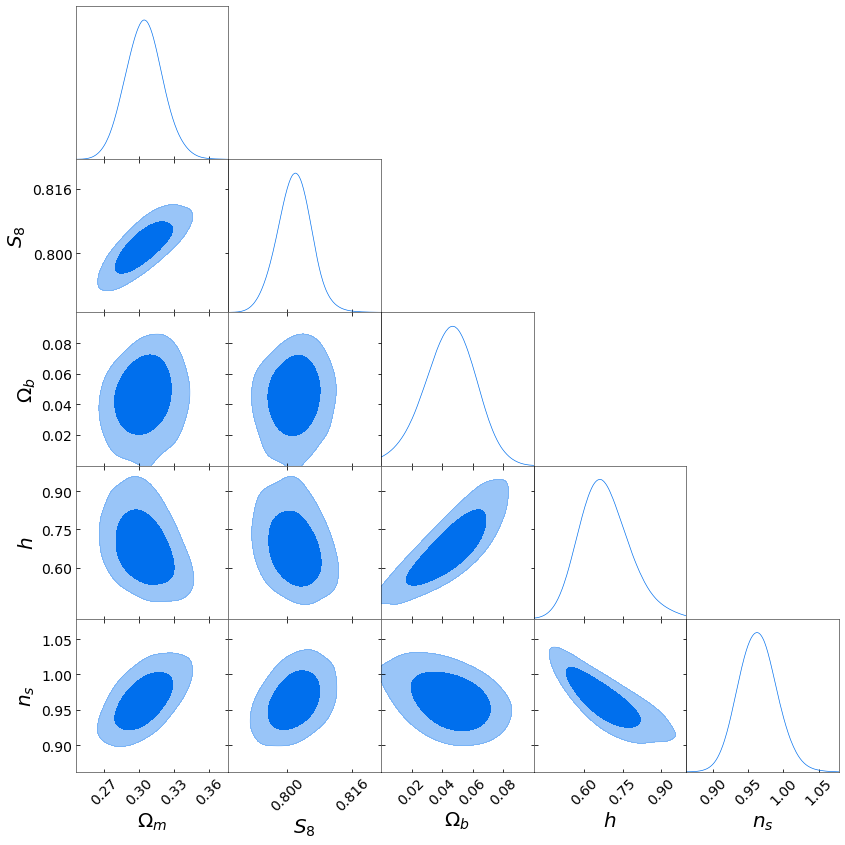

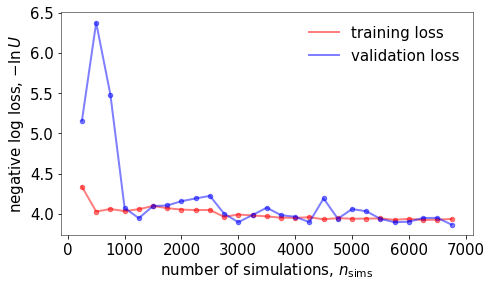

Population 27/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


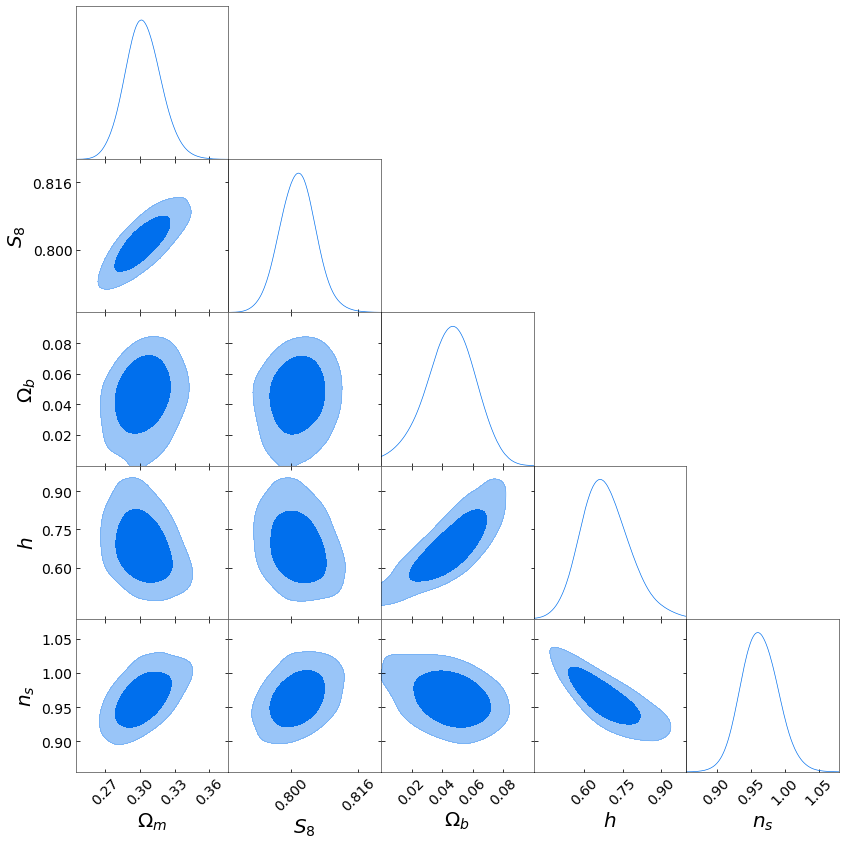

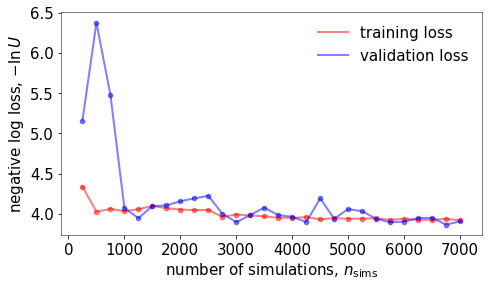

Population 28/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


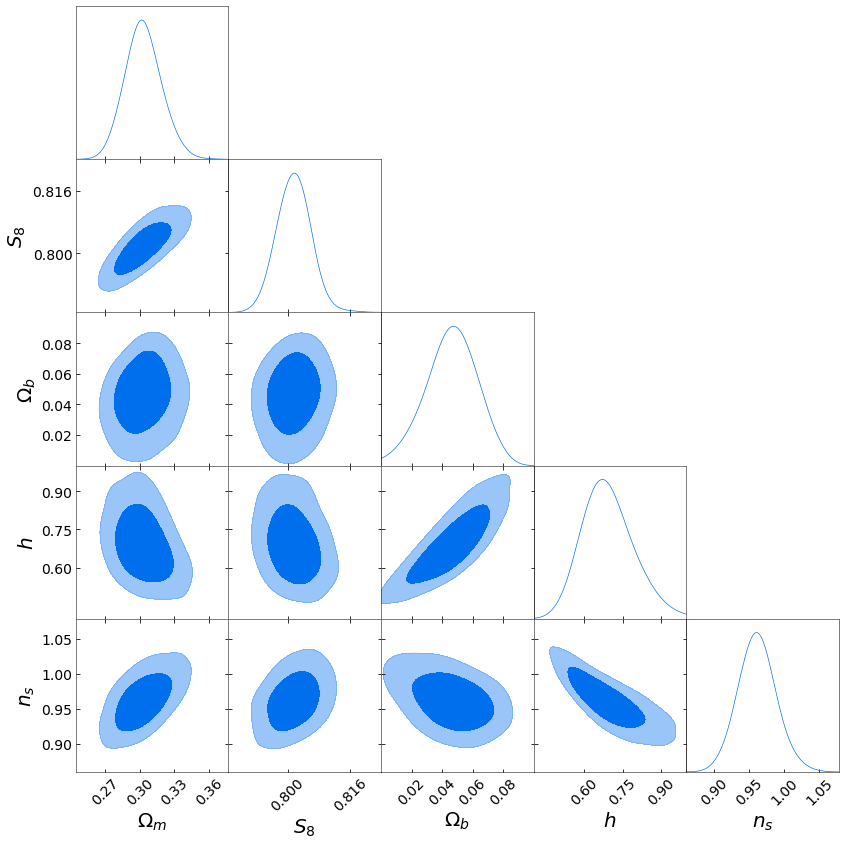

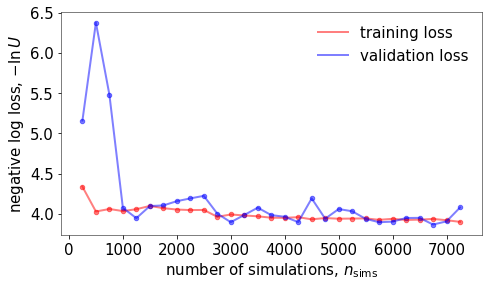

Population 29/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


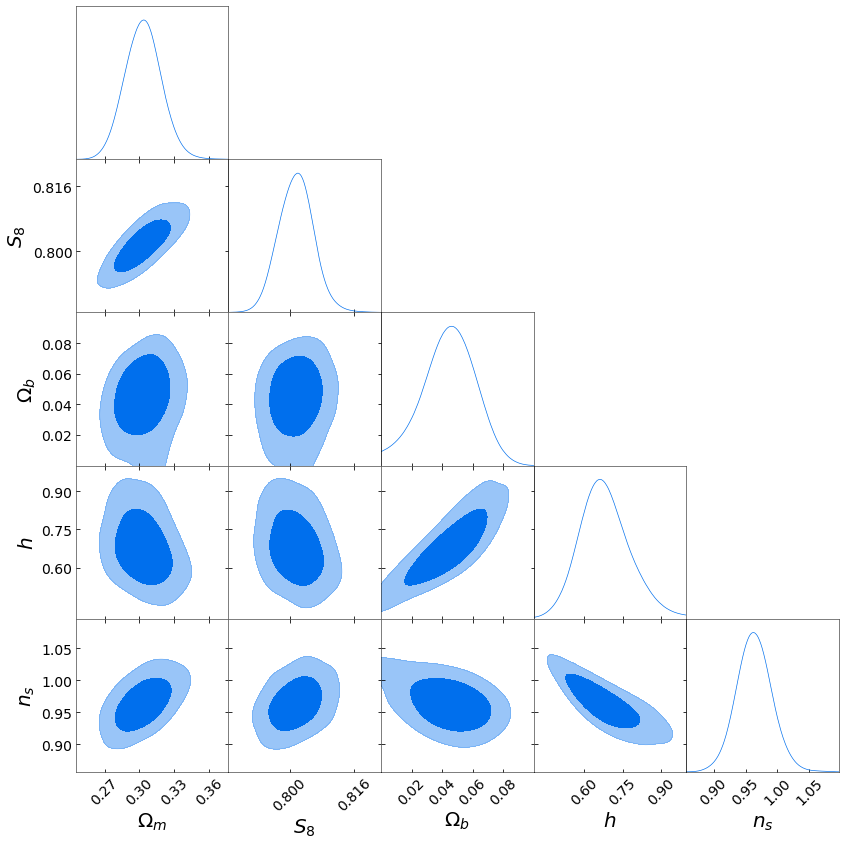

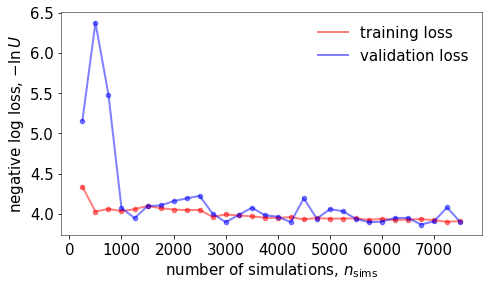

Population 30/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


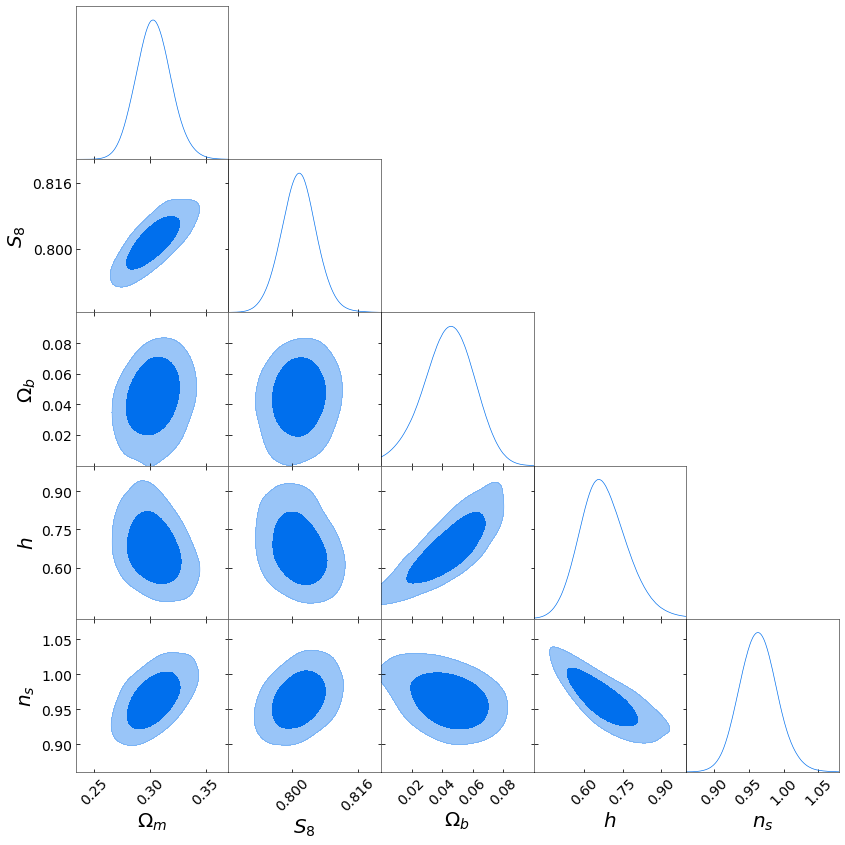

Population 31/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Population 32/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


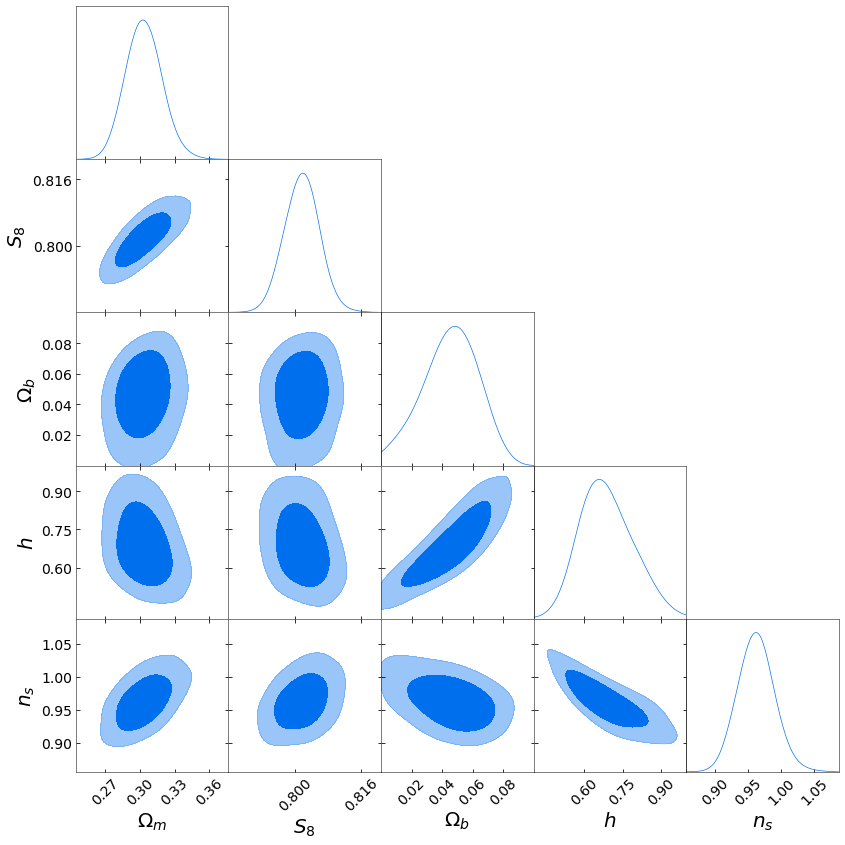

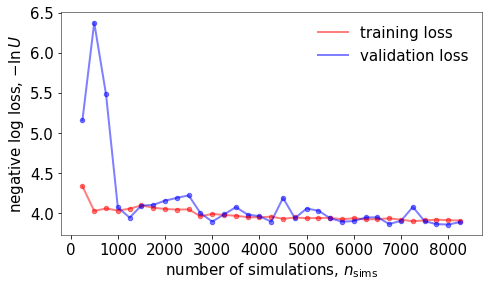

Population 33/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


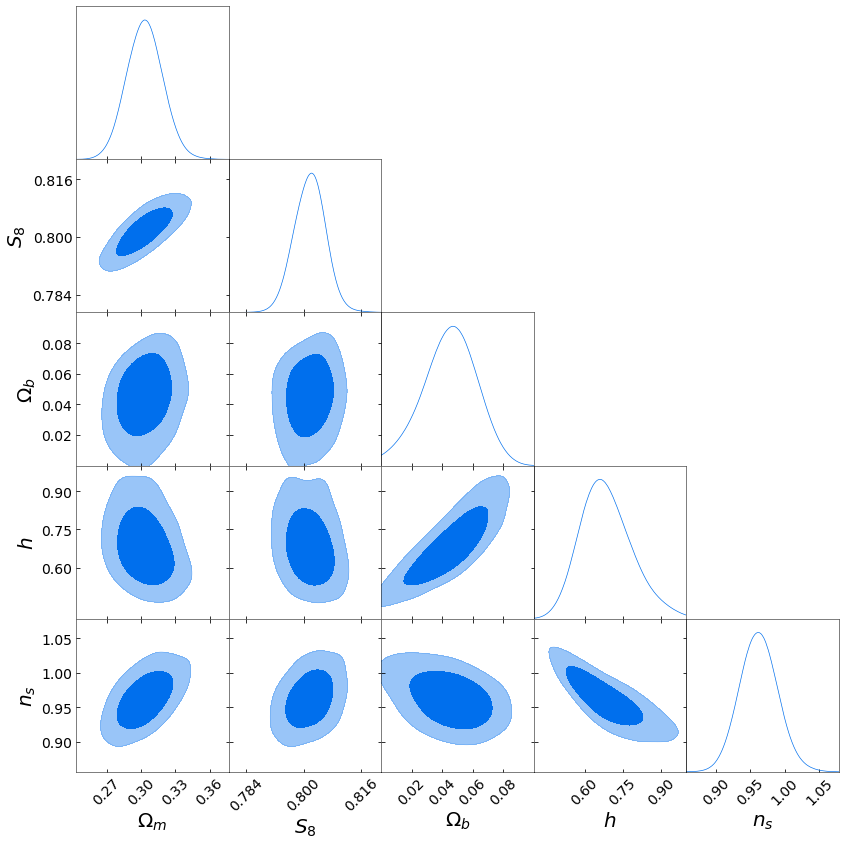

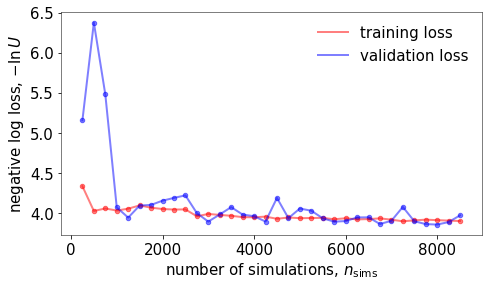

Population 34/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


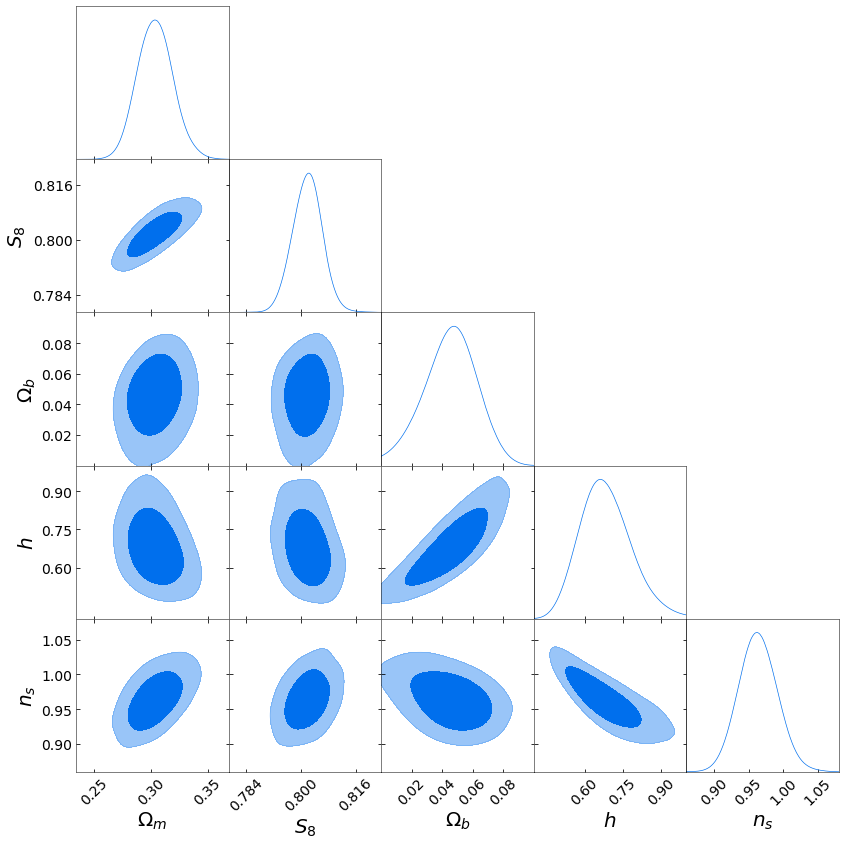

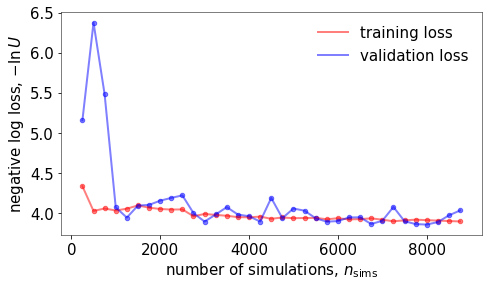

Population 35/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


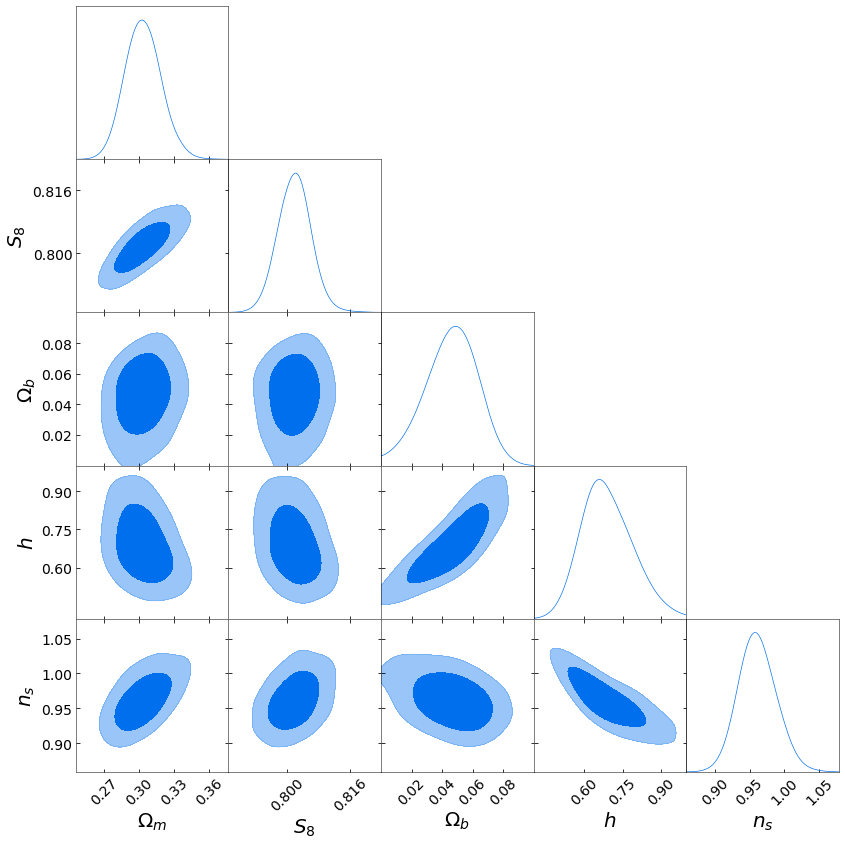

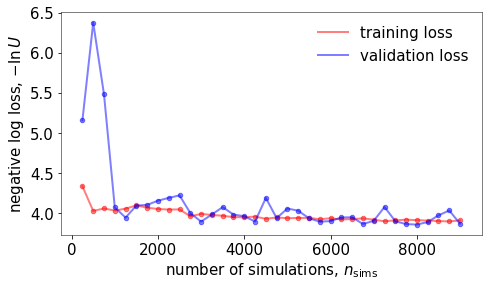

Population 36/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


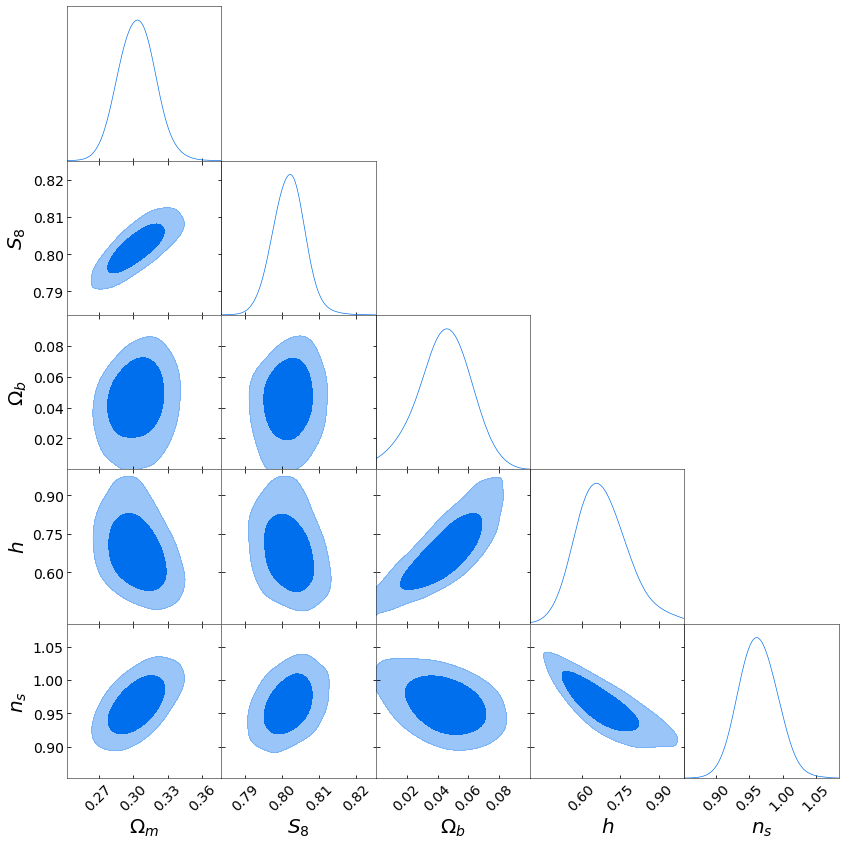

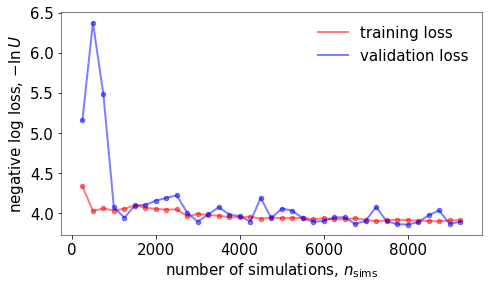

Population 37/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


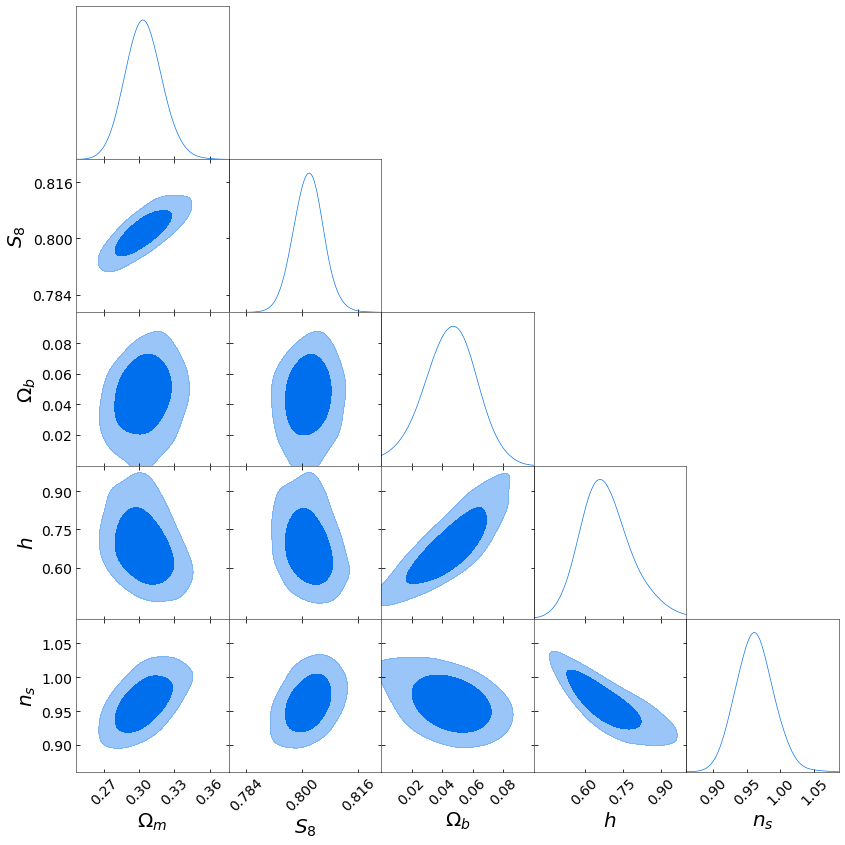

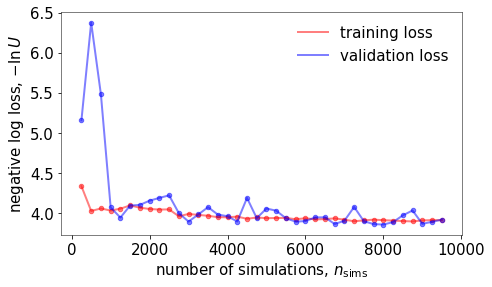

Population 38/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


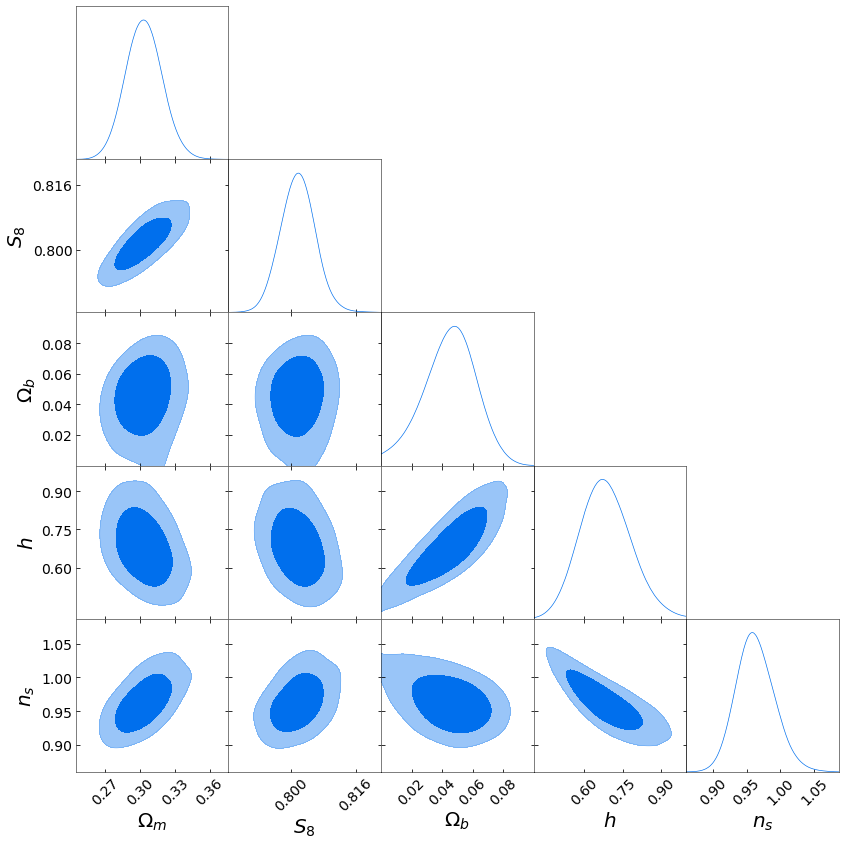

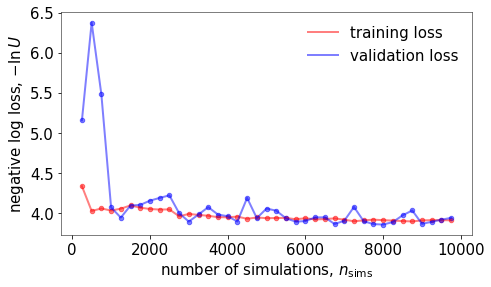

Population 39/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


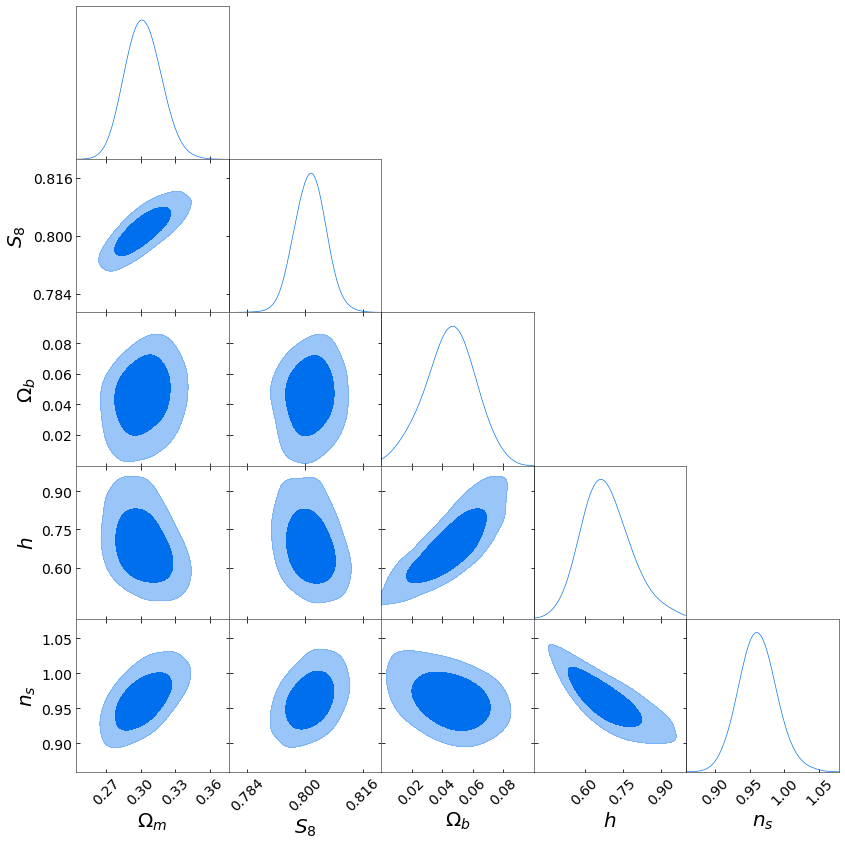

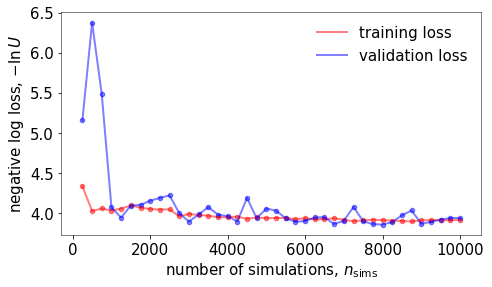

Population 40/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


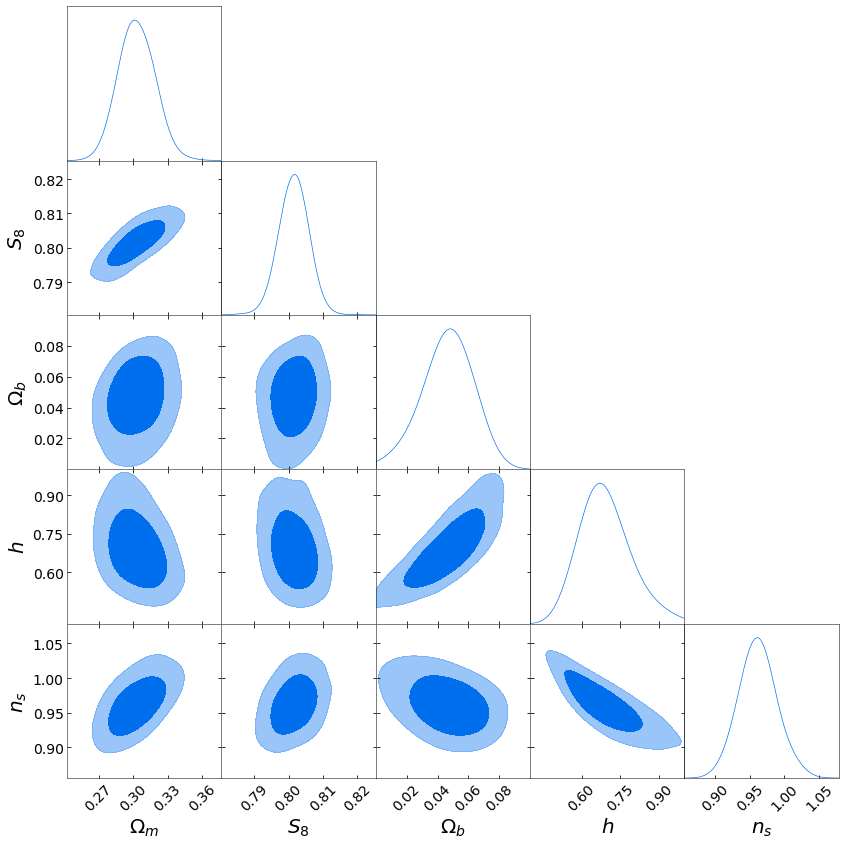

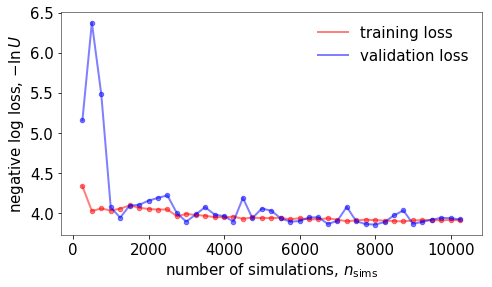

Population 41/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


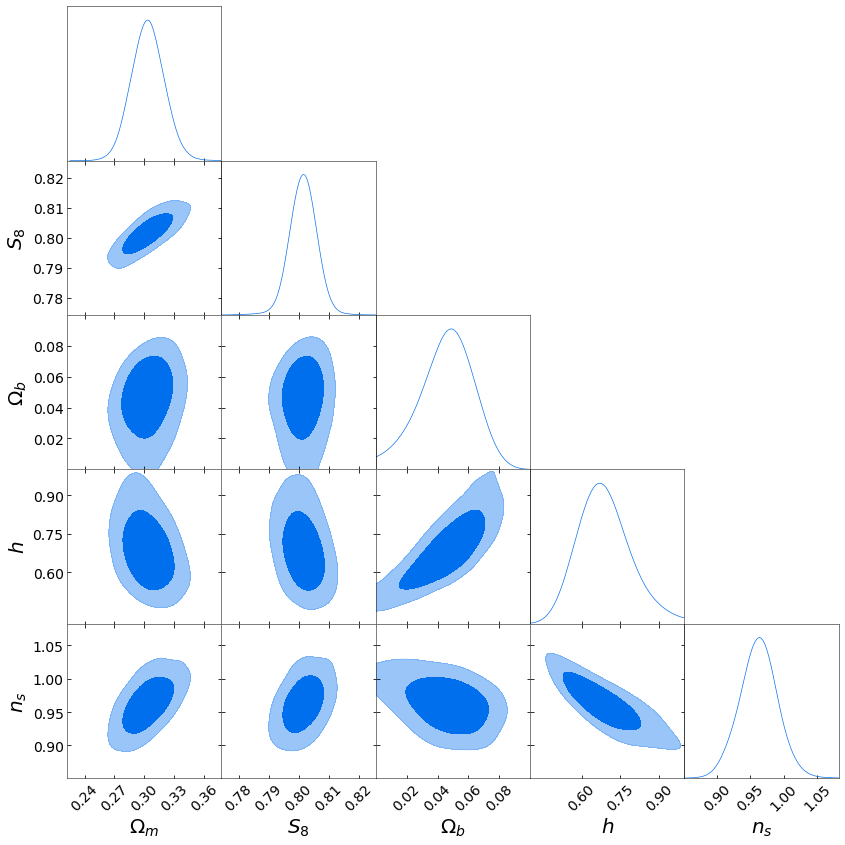

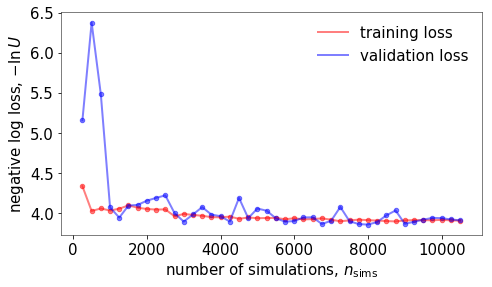

Population 42/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


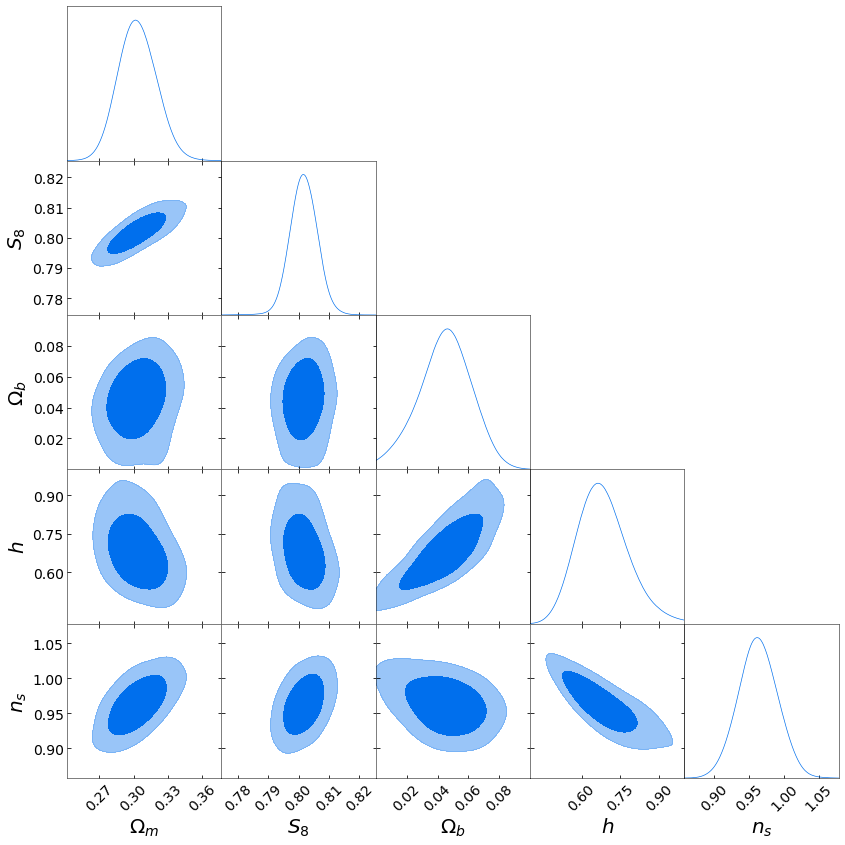

Population 43/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


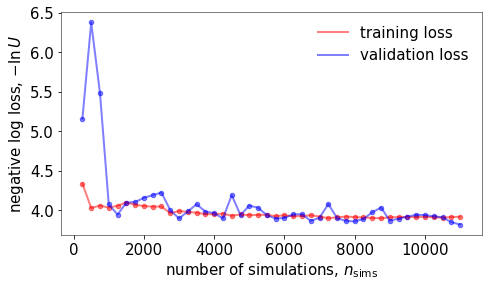

Population 44/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


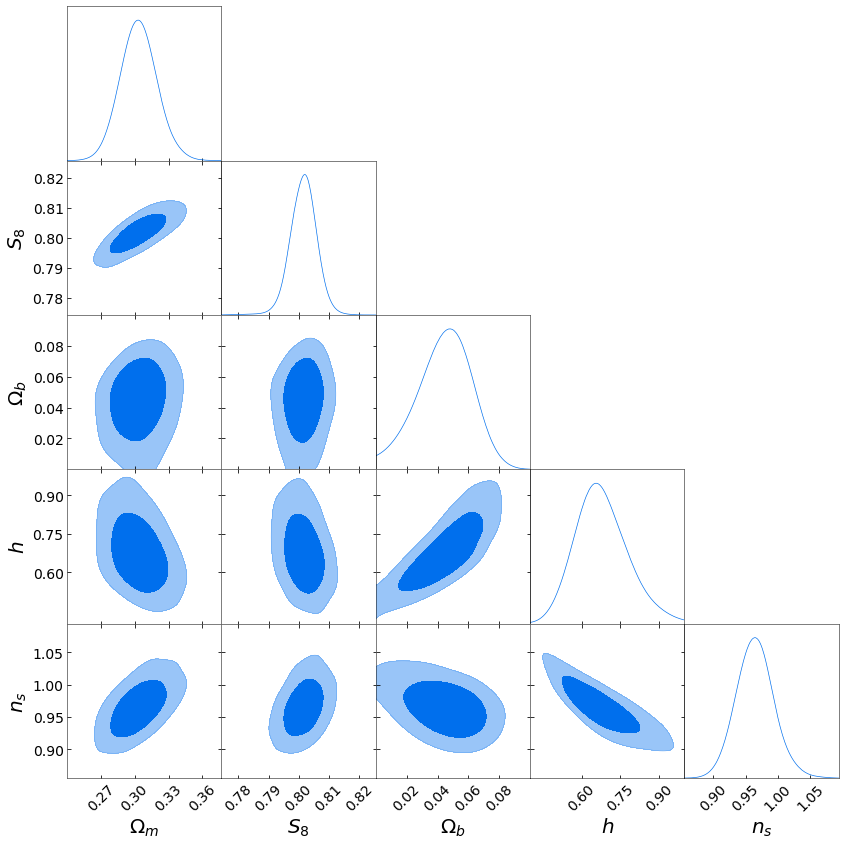

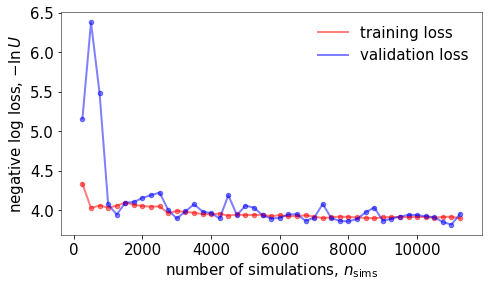

Population 45/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


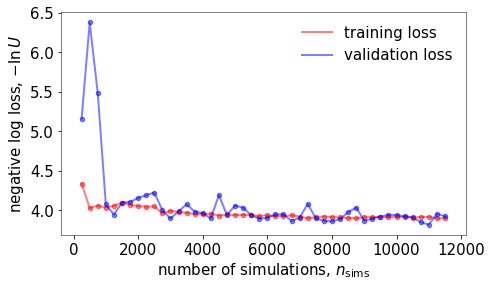

Population 46/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


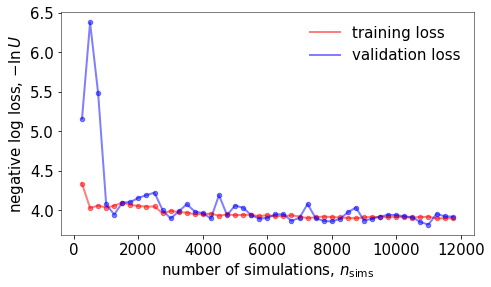

Population 47/47
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [9]:
# Initial samples, batch size for population samples, number of populations
n_initial = 250
n_batch = 250
n_populations = 47

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, simulator_args=simulator_args)

In [ ]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_marginal/maf")

In [ ]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining()

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


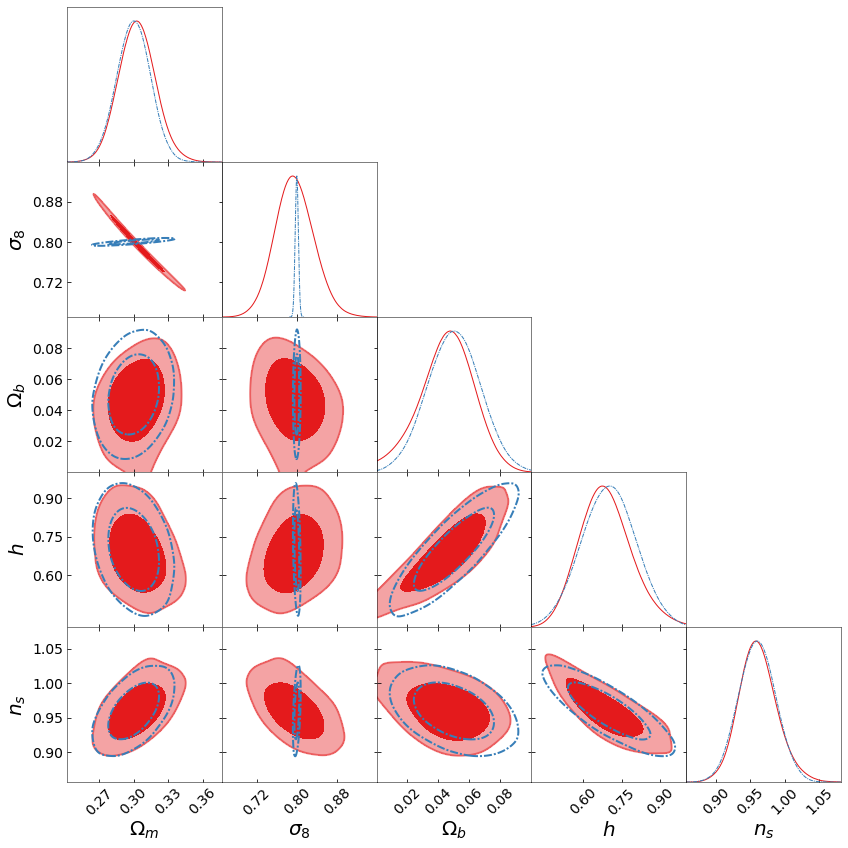

In [21]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])

samples = [DelfiMDN.posterior_samples, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2
g.settings.lw1 = 2
g.settings.lw_likes = 2
#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
#plt.savefig('../paper_II/plots/contours.pdf')

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


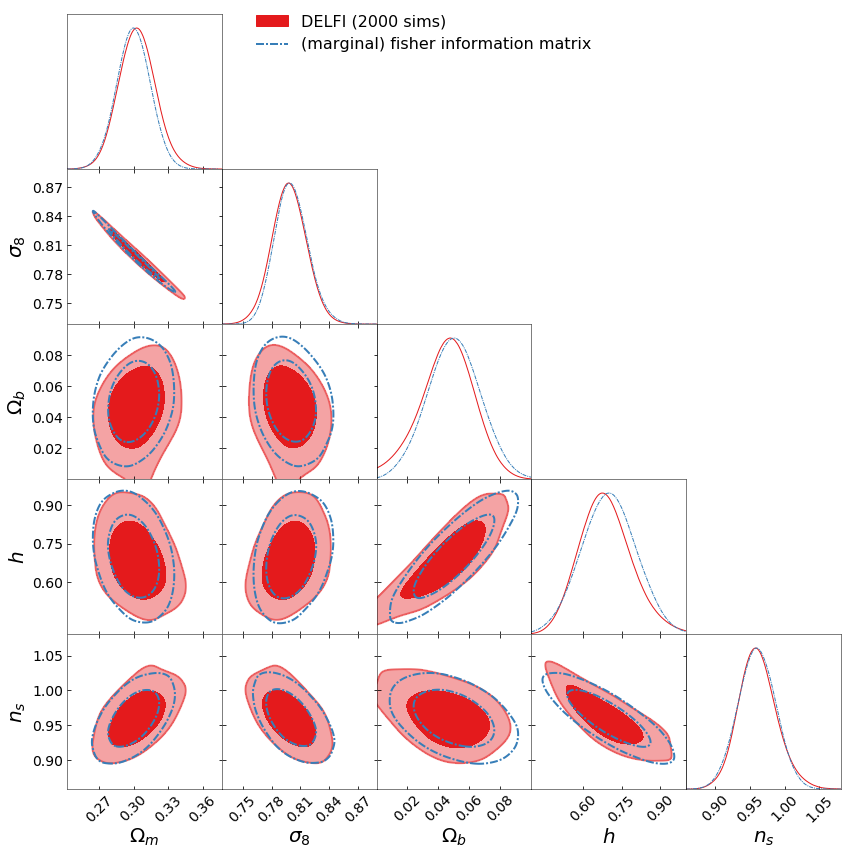

In [31]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5
samples_delfi = np.loadtxt('simulators/cosmic_shear/results_marginal/mdnposterior_samples_47.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'
samples = [samples_delfi, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])
g.add_legend(legend_labels=['DELFI (2000 sims)', '(marginal) fisher information matrix'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('../../paper_II/plots/cosmic_shear_marginalized_contours.pdf')

In [40]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5

samples_mcmc = np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples_systematics1.dat')[:,0:5]
samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5

samples_delfi = np.loadtxt('simulators/cosmic_shear/results_marginal/mdnposterior_samples_47.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'

samples = [samples_delfi, samples_mcmc, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1, 1], contour_ls = ['-','-', '-.'], contour_colors=['#E41A1C','black', '#377EB8'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC', '(marginal) fisher information'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
#plt.savefig('../../paper_II/plots/cosmic_shear_marginalized_contours_mcmc.pdf')

Removed no burn in
Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


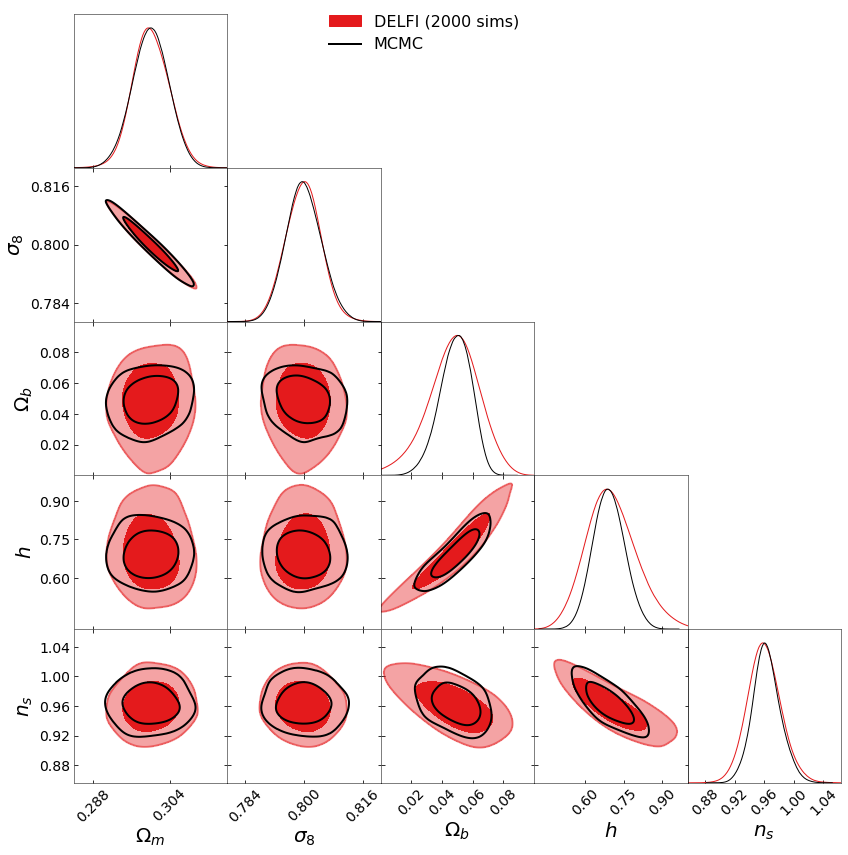

In [43]:
# Compare error ellipses with expected Fisher errors

# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)
samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])
samples_asymptotic[:,1] = samples_asymptotic[:,1]*(0.3/samples_asymptotic[:,0])**0.5

samples_mcmc = np.loadtxt('simulators/cosmic_shear/mcmc/emcee_samples1.dat')[:,0:5]
samples_mcmc[:,1] = samples_mcmc[:,1]*(0.3/samples_mcmc[:,0])**0.5

samples_delfi = np.loadtxt('simulators/cosmic_shear/results/mdnposterior_samples_24.dat')
samples_delfi[:,1] = samples_delfi[:,1]*(0.3/samples_delfi[:,0])**0.5
new_names = DelfiMDN.names
new_names[1] = '\sigma_8'

samples = [samples_delfi, samples_mcmc]
mc_samples = [MCSamples(samples=s, names = DelfiMDN.names, labels = DelfiMDN.labels, ranges = DelfiMDN.ranges) for s in samples]

# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-'], contour_colors=['#E41A1C','black'])
g.add_legend(legend_labels=['DELFI (2000 sims)', 'MCMC'], figure=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('../../paper_II/plots/cosmic_shear_contours_mcmc.pdf')